# Import libraries

In [102]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns

from sklearn.metrics import roc_auc_score

# About dataset

Purpose of the problem is to predict the sale price of each property. The target variable is called price_doc.

The training data is from August 2011 to June 2015, and the test set is from July 2015 to May 2016. The dataset also includes information about overall conditions in Russia's economy and finance sector.

You can find more information about dataset in __data/data_dictionary.txt__

In [92]:
xtrain = pd.read_csv('data/train.csv')

In [93]:
id_train = xtrain['id']
time_train = xtrain['timestamp']
ytrain = xtrain['price_doc']
xtrain.drop(['id', 'timestamp', 'price_doc'], axis = 1, inplace = True)
xtrain.fillna(-1, inplace = True)

In [94]:
xtest = pd.read_csv('data/test.csv')
id_test = xtest['id']            
time_test = xtest['timestamp']
xtest.drop(['id', 'timestamp'], axis = 1, inplace = True)
xtest.fillna(-1, inplace = True)

In [95]:
xtest.shape

(7662, 289)

# What is concept drift?

Data can change over time. This can result in poor and degrading predictive performance in predictive models that assume a static relationship between input and output variables. This problem of the changing underlying relationships in the data is called concept drift in the field of machine learning.

The term “concept drift” is related to, but distinct from “data drift”. The shift in the relationships between input and output data in the underlying issue over time is called concept drift in machine learning. 

Concept drift in machine learning and data mining refers to the change in the relationships between input and output data in the underlying problem over time.

# What is Adversarial Validation?

As you know, cross-validation allows you to test your
model’s ability to generalize to unseen datasets coming from the
same distribution as your training data. 

Even if you do not overfit to the test data because you have based
your decision not only on metrics but also
considered your cross-validation, you may still be surprised by the
results.

This could happen in the event that the test set is even
slightly different from the training set on which you have based your
model. In fact, the target probability and its distribution, as well as
how the predictive variables relate to it, inform your model during
training about certain expectations that cannot be satisfied if the test
data is different from the training data.


It is also advisable
to find out if your test data is comparable to the training data. Then,
if they differ, you have to figure out if there is any chance that you
can mitigate the different distributions between training and test
data and build a model that performs on that test set.

__Adversarial validation has been developed just for this purpose. It is
a technique allowing you to easily estimate the degree of difference
between your training and test data.__

# Concept drift detection via Adversarial Validation 

Adversarial validation approach can be used in
concept drift problems in production models. With
this approach, the system detects concept drift in new data before
making inference, trains a model, and produces predictions adapted
to the new data. 

The idea is simple: __take your training data, remove the target,
assemble your training data together with your test data, and create
a new binary classification target where the positive label is assigned
to the test data.__



In [97]:
xtrain['istrain'] = 1
xtest['istrain'] = 0
xdat = pd.concat([xtrain, xtest], axis = 0)
xdat = xdat.sample(frac=1).reset_index(drop = True)
# convert non-numerical columns to integers
df_numeric = xdat.select_dtypes(exclude=['object'])
df_obj = xdat.select_dtypes(include=['object']).copy()

In [74]:
for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]
    
xdat = pd.concat([df_numeric, df_obj], axis=1)

In [75]:
xdat_labeled = xdat.copy()

In [16]:
y = xdat['istrain']
xdat.drop('istrain', axis = 1, inplace = True)

In [18]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 44)

xgb_params = {
        'learning_rate': 0.05, 'max_depth': 4,'subsample': 0.9,
        'colsample_bytree': 0.9,'objective': 'binary:logistic',
        'silent': 1, 'n_estimators':100, 'gamma':1,
        'min_child_weight':4
        }   

clf = xgb.XGBClassifier(**xgb_params, seed = 10)     

At this point, run a machine learning classifier and evaluate for the ROC-AUC evaluation metric on StratifiedKFold results.

If your ROC-AUC is around 0.5, it means that the training and test
data are not easily distinguishable and are apparently from the same
distribution.

ROC-AUC values higher than 0.5 and nearing 1.0 signal
that it is easy for the algorithm to figure out what is from the
training set and what is from the test set: in such a case, don’t expect
to be able to easily generalize to the test set because it clearly comes
from a different distribution.

In [21]:
for train_index, test_index in skf.split(xdat, y):
        x0, x1 = xdat.iloc[train_index], xdat.iloc[test_index]
        y0, y1 = y.iloc[train_index], y.iloc[test_index]  
        
        clf.fit(x0, y0, eval_set=[(x1, y1)],
               eval_metric='logloss', verbose=False,early_stopping_rounds=10)
                
        prval = clf.predict_proba(x1)[:,1]
        print('For one fold, roc auc score: ', roc_auc_score(y1,prval))

C:\Users\004567\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:20:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


For one fold, roc auc score:  0.9496227593134808


C:\Users\004567\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:20:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


For one fold, roc auc score:  0.949812365568263


C:\Users\004567\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:20:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


For one fold, roc auc score:  0.9435663408513416


C:\Users\004567\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:20:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


For one fold, roc auc score:  0.9510273020331603


C:\Users\004567\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:20:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


For one fold, roc auc score:  0.9517224599636162


As you see, in all validation sets __roc_auc_score is above 0.95__ which means that model easily distinguish train and test sets using adversarial validation.

Now let's expand our investigation of dataset and look at distribution of features in train and test sets with respect to Kolmogorov-Smirnov test.

# What is Kolmogorov-Smirnov test?

Two-sample Kolmogorov-Smirnov test to compare the distributions of values in two data sets. For each potential value x, the Kolmogorov-Smirnov test compares the proportion of values in the first sample less than x with the proportion of values in the second sample less than x. The null hypothesis is that the two samples have the same continuous distribution. The alternative hypothesis is that they have different continuous distributions.

Kolmogorov–Smirnov test a very efficient way to determine if two samples are significantly different from each other.

# Concept drift detection via Kolmogorov-Smirnov test

The main goal of concept drift detection is to determine if two distributions are different. Therefore, the first and most basic approach to infer concept drift applies a hypothesis test to flag if a statistically significant change has occurred between the reference and detection windows for each feature in a given data stream.

For continuous features, we use a two-sample Kolmogorov-Smirnov (KS) test, which is a non-parametric hypothesis test used to check whether two samples originate from the same distribution.

In [135]:
def preprocess_data(df): 
    df.fillna(-1, inplace = True)

    df_numeric = df.select_dtypes(exclude=['object'])
    df_obj = df.select_dtypes(include=['object']).copy()
    for c in df_obj:
        df_obj[c] = pd.factorize(df_obj[c])[0]

    df = pd.concat([df_numeric, df_obj], axis=1)
    return df

xtrain = preprocess_data(xtrain)
xtest = preprocess_data(xtest)

The advantage of this test is that it’s non-parametric in nature, therefore it is distribution agnostic.


If the p-value is less than .05, we reject the null hypothesis. We have sufficient evidence to say that the two sample datasets do not come from the same distribution and it can cause concept drift.

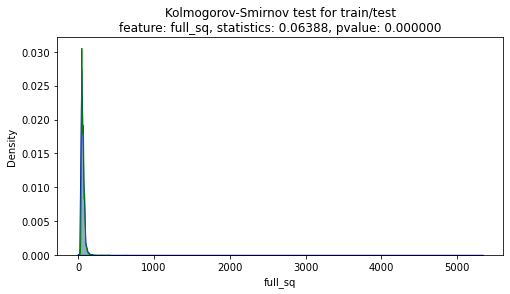

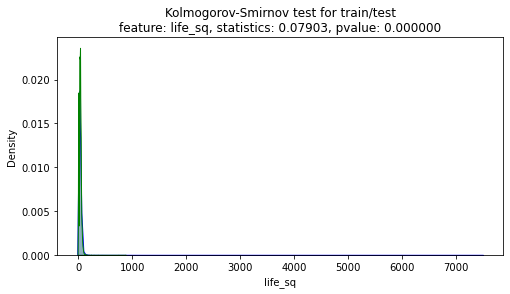

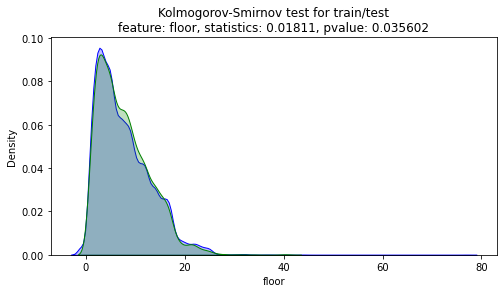

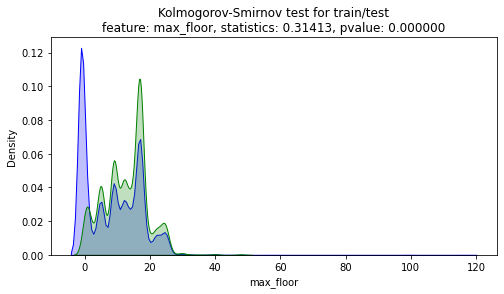

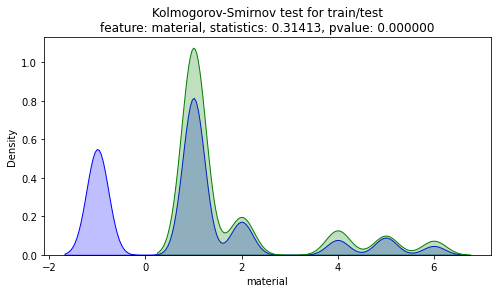

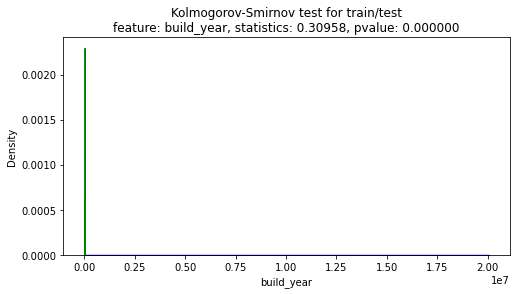

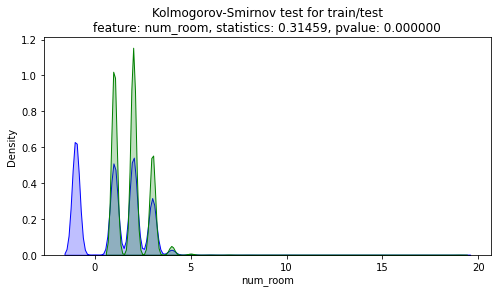

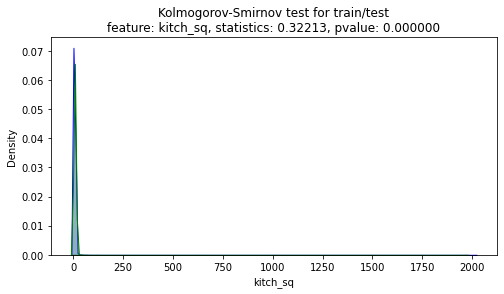

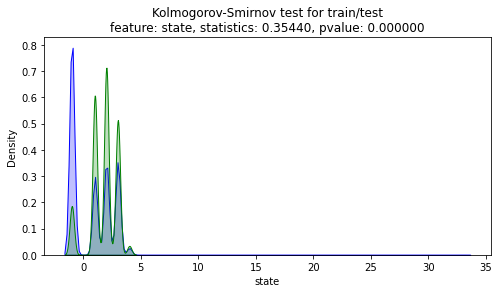

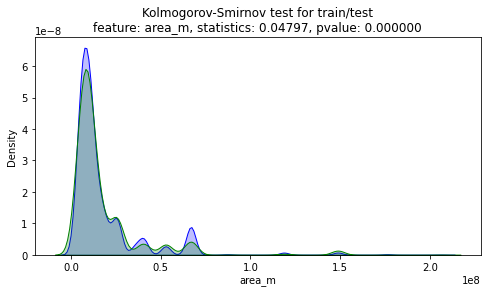

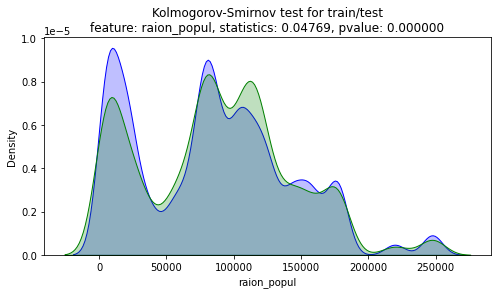

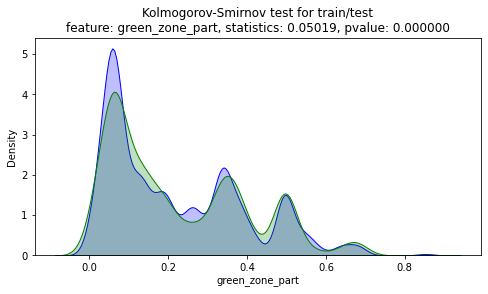

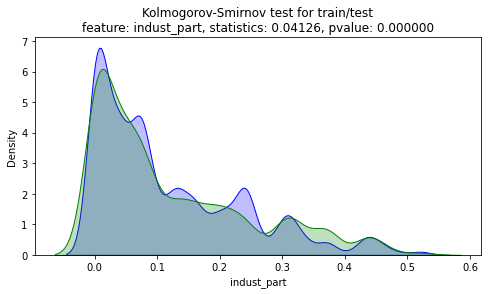

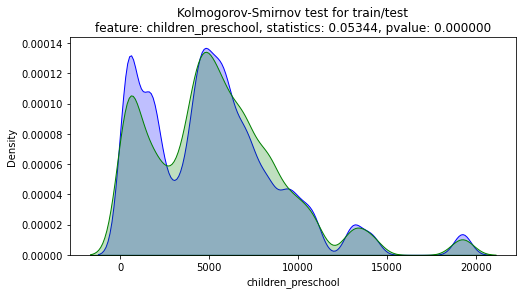

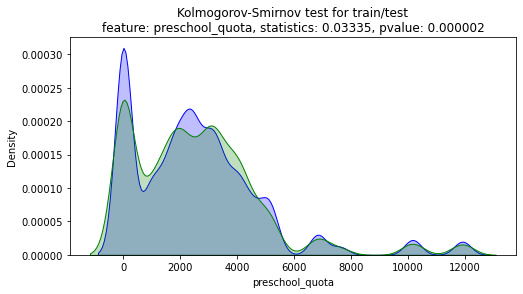

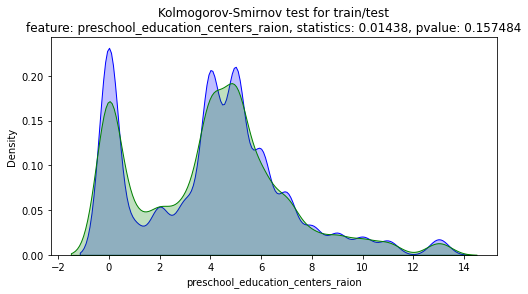

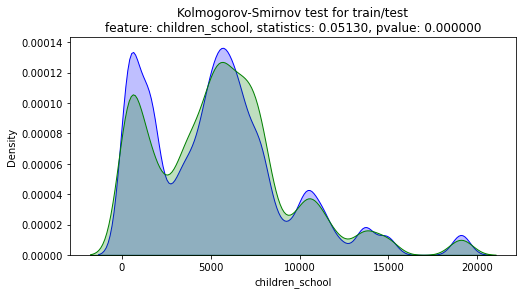

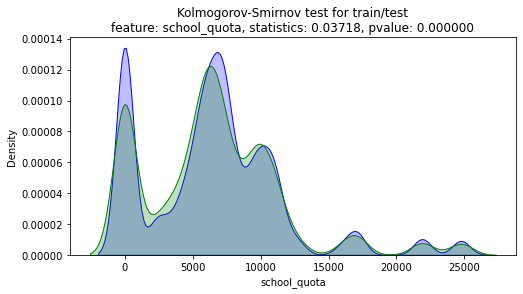

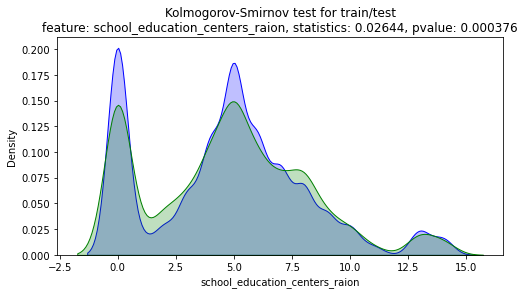

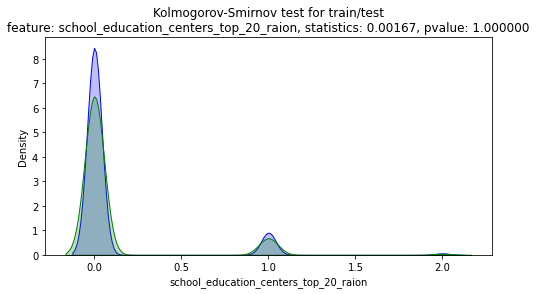

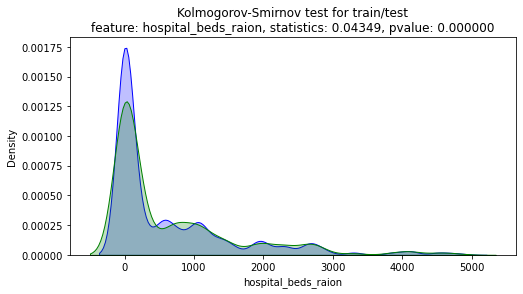

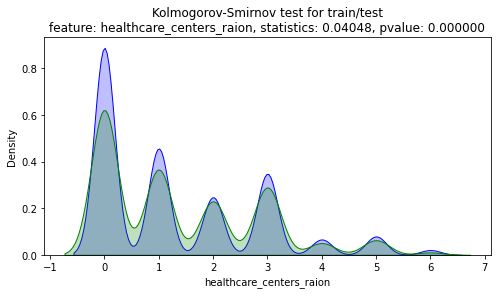

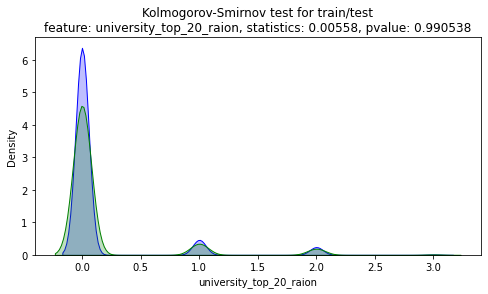

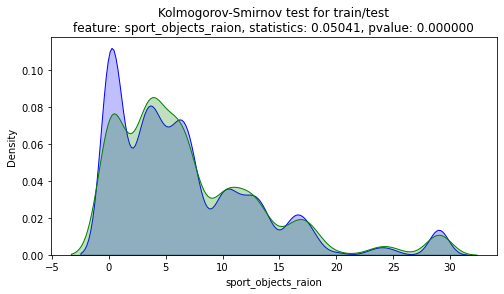

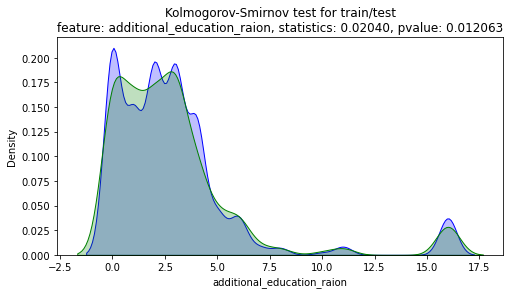

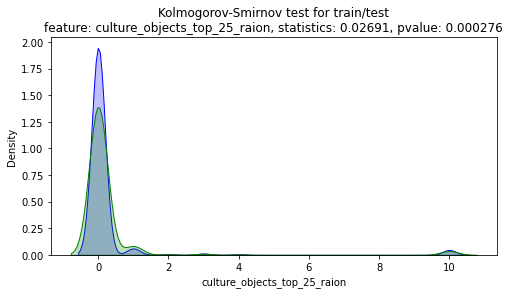

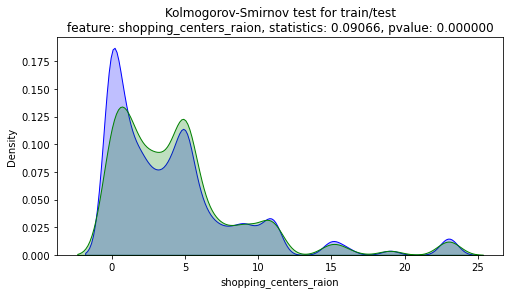

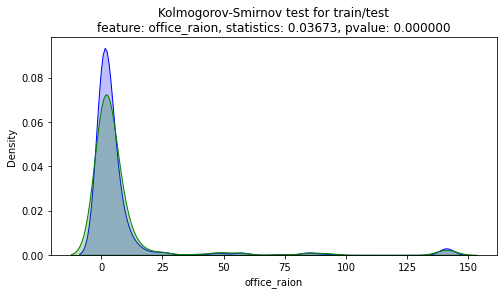

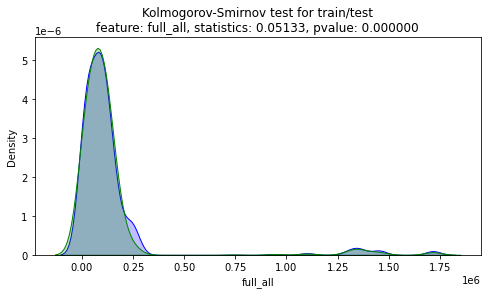

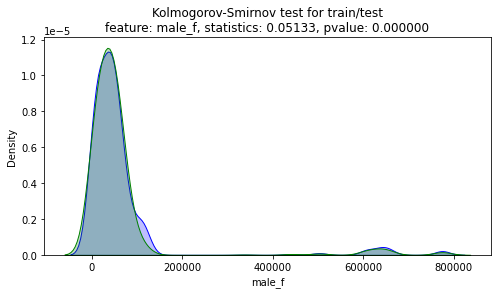

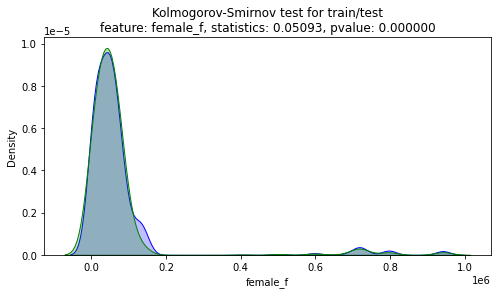

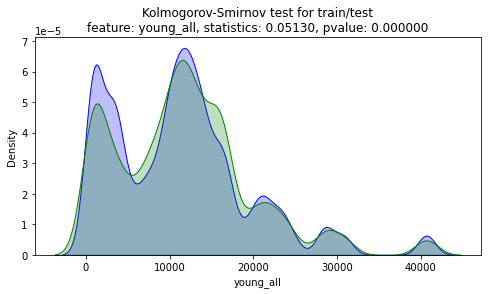

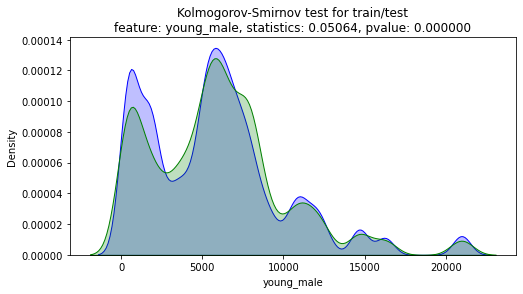

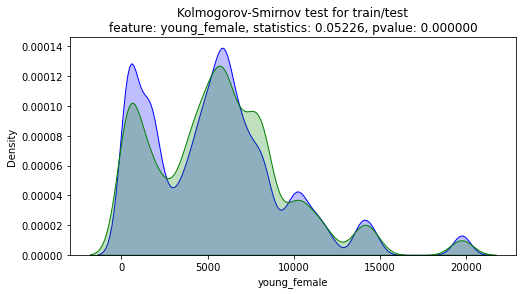

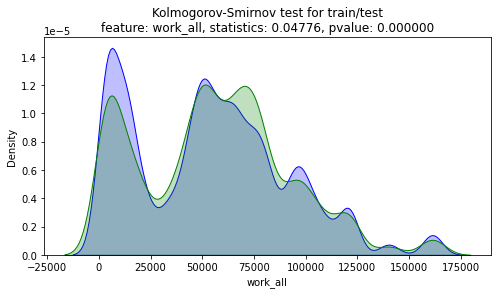

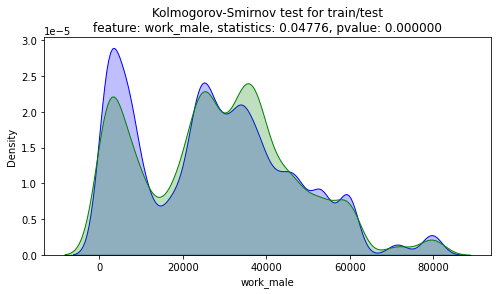

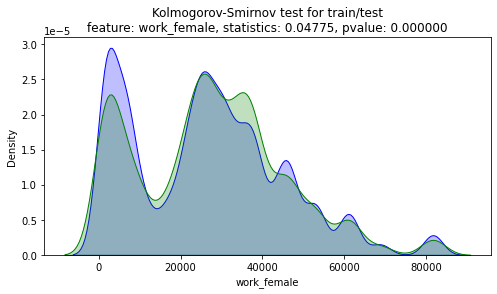

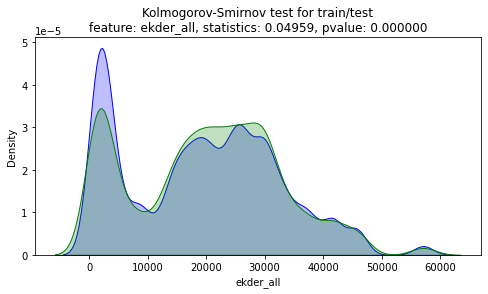

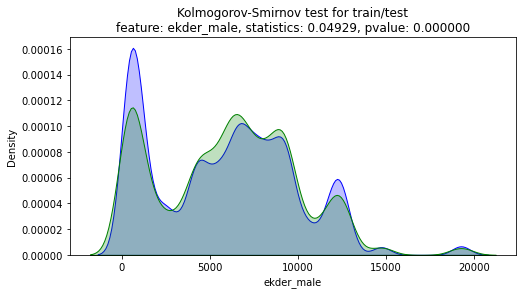

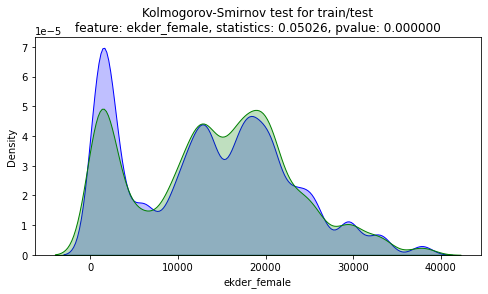

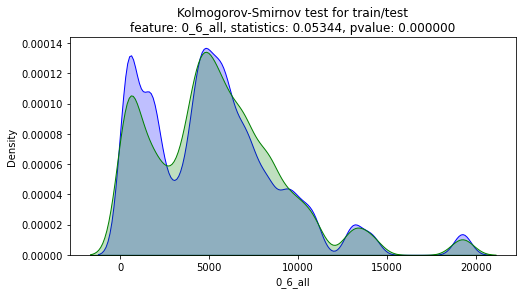

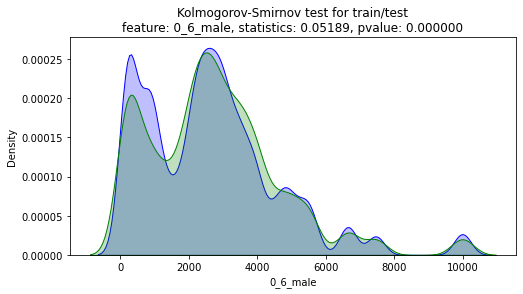

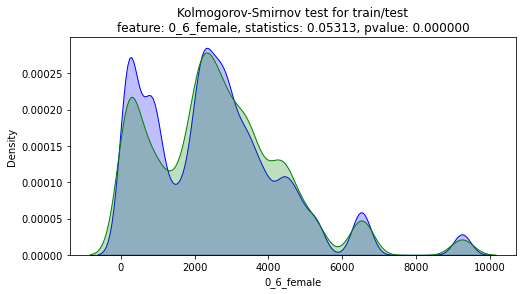

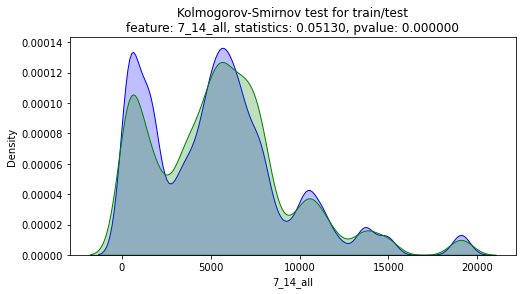

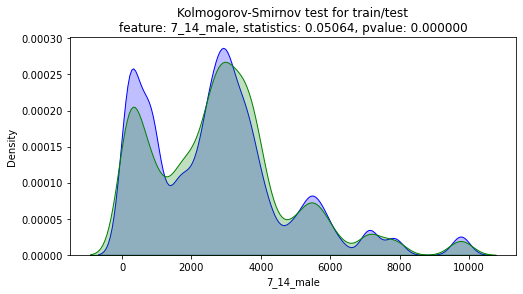

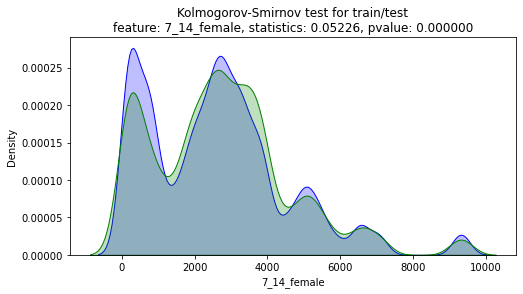

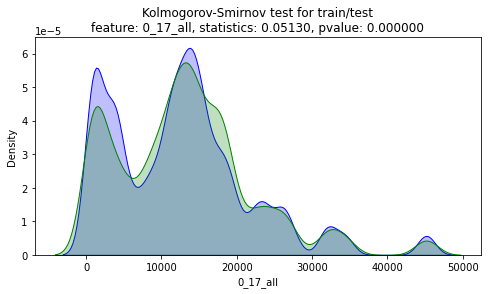

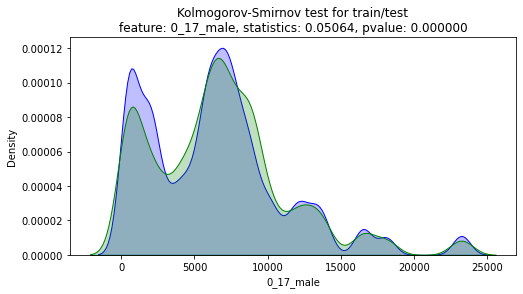

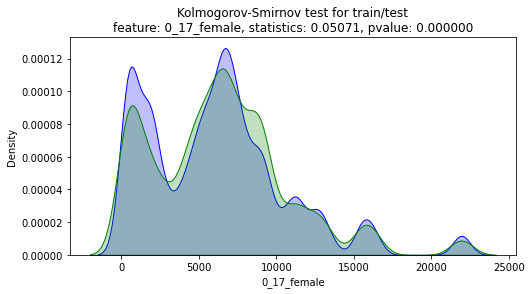

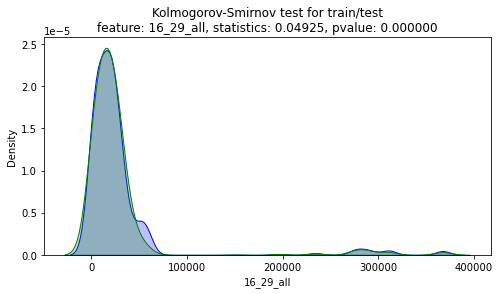

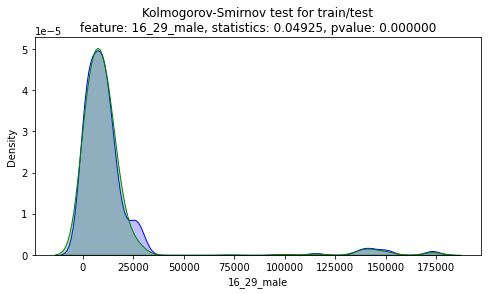

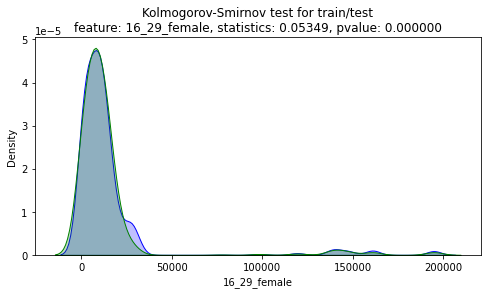

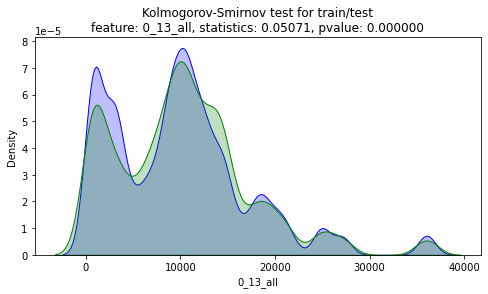

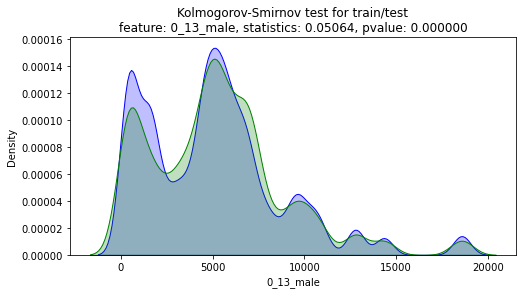

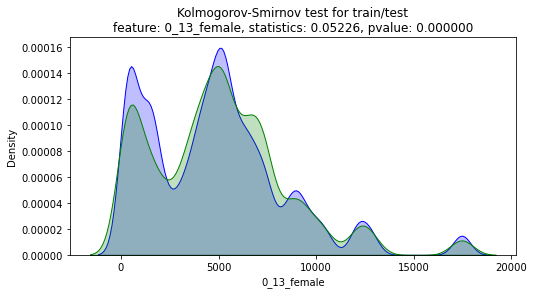

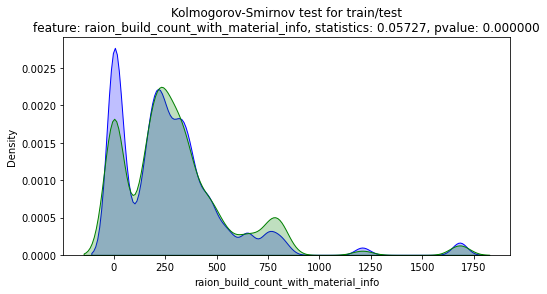

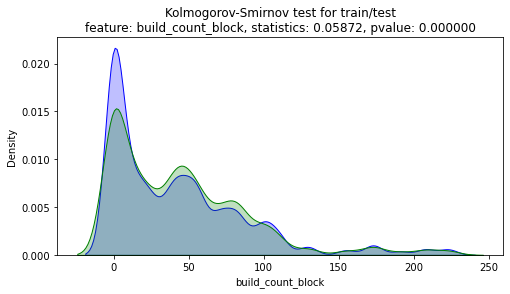

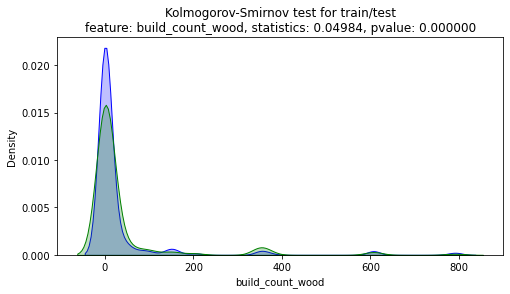

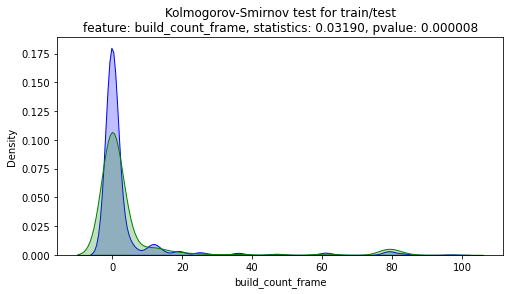

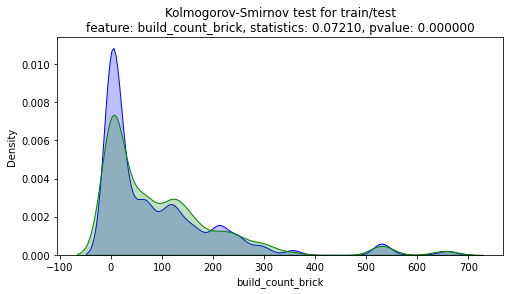

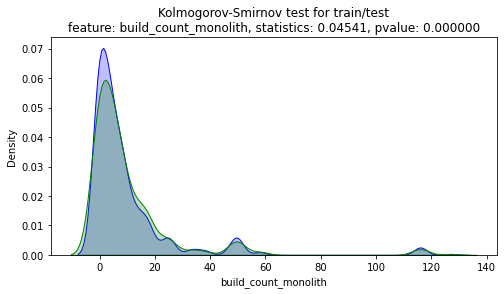

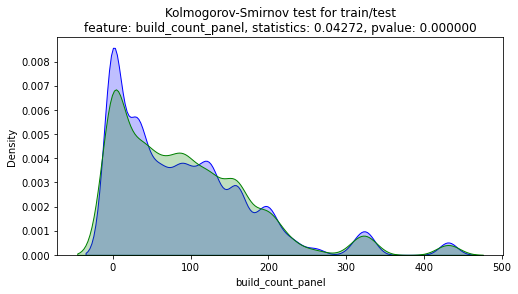

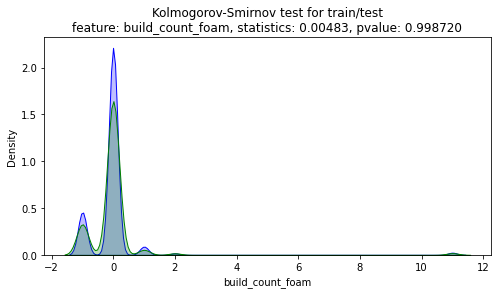

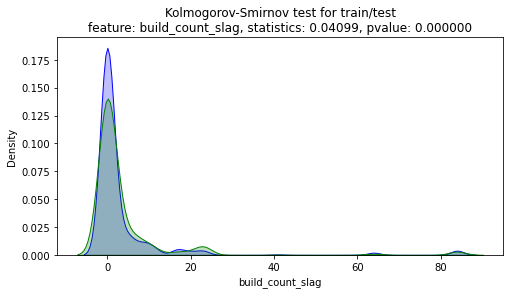

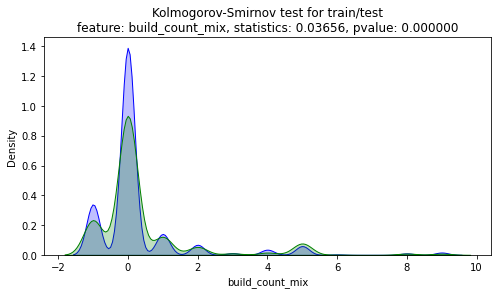

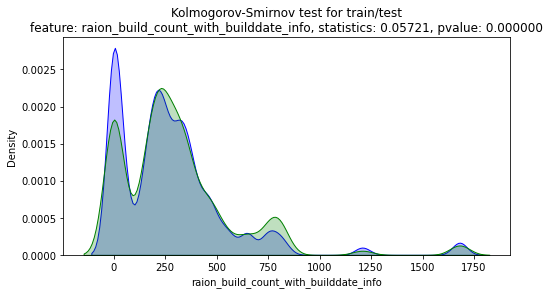

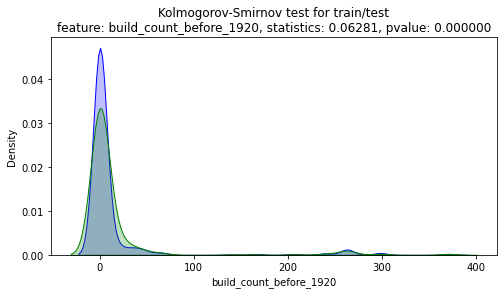

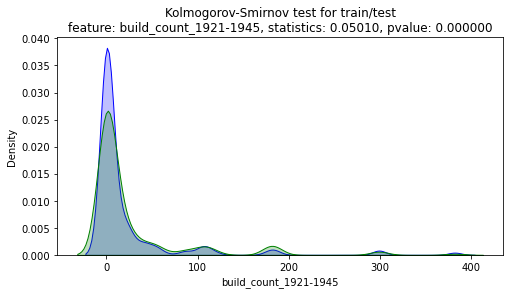

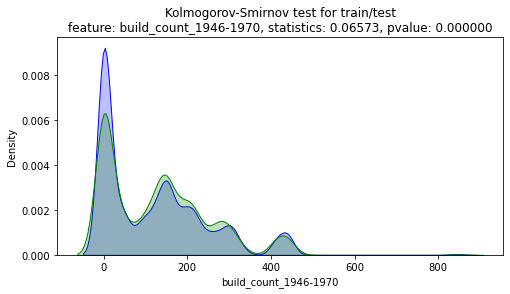

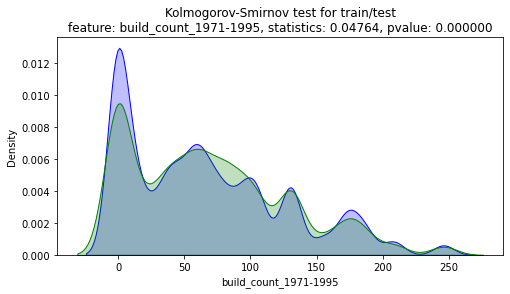

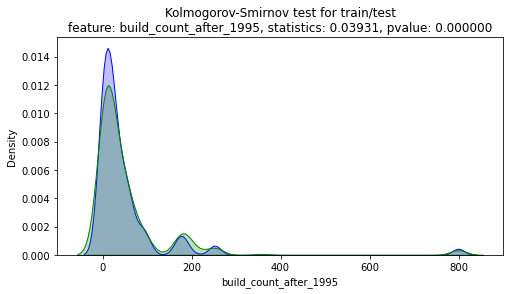

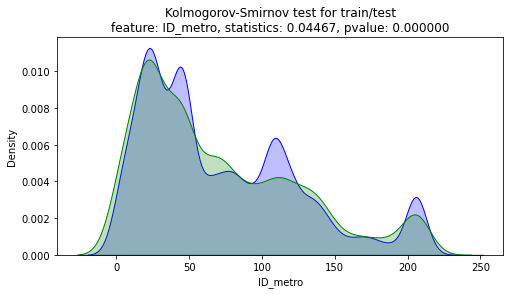

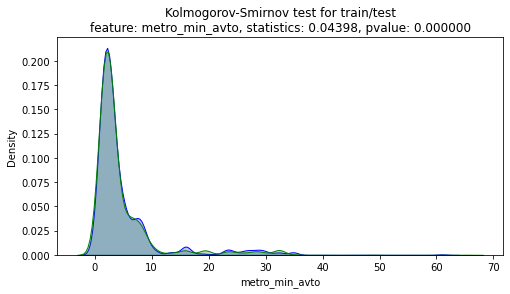

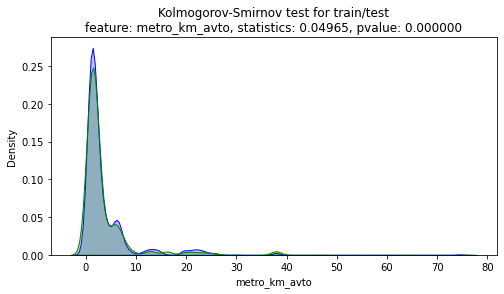

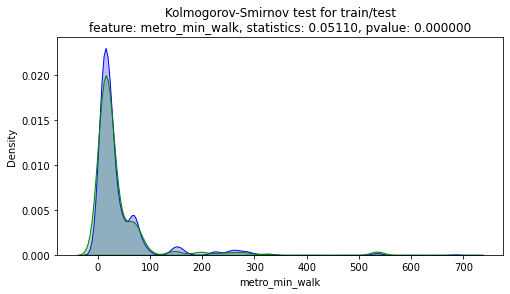

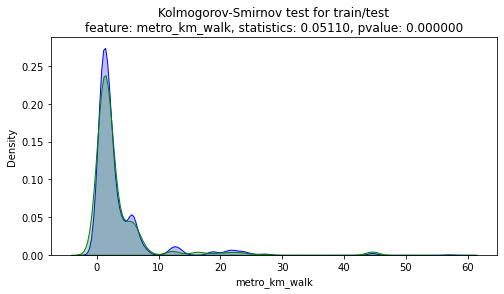

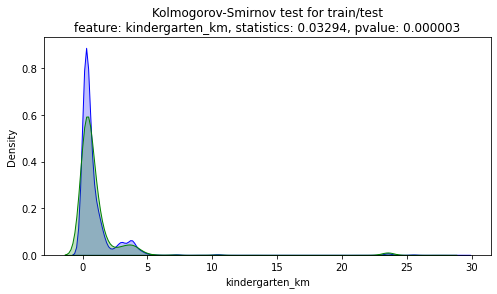

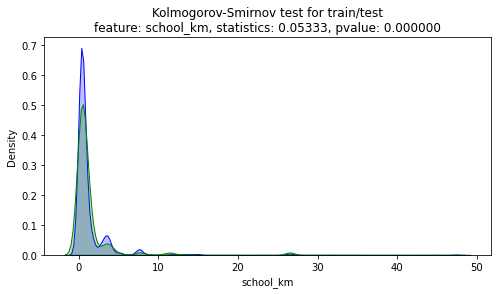

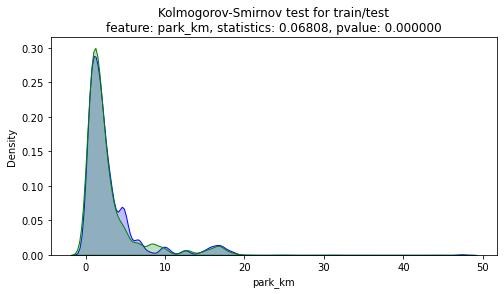

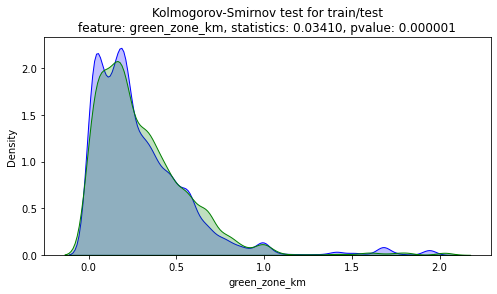

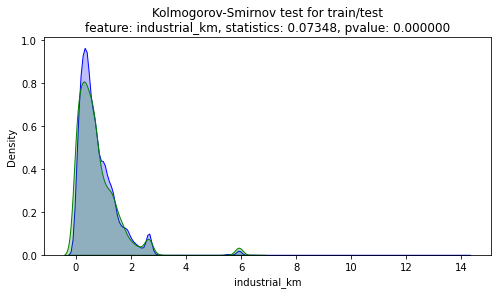

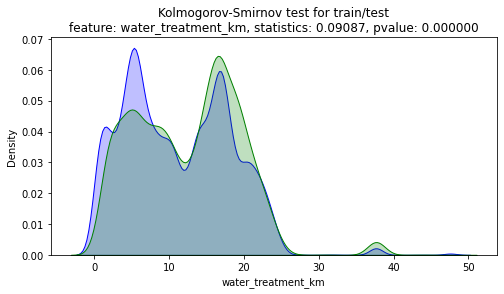

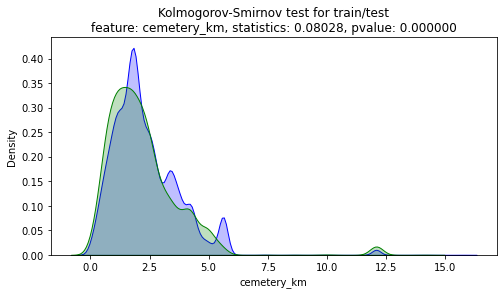

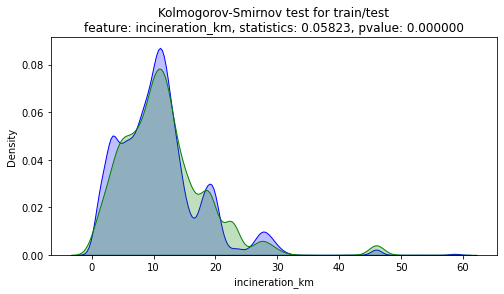

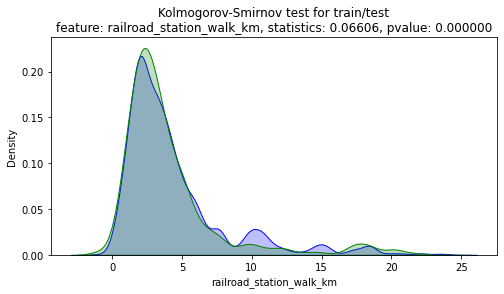

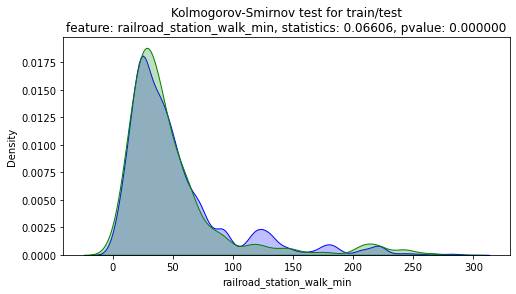

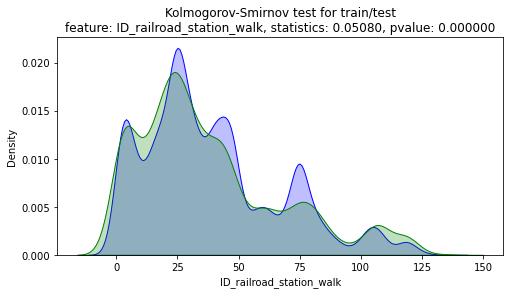

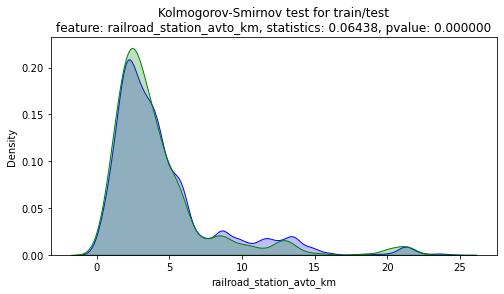

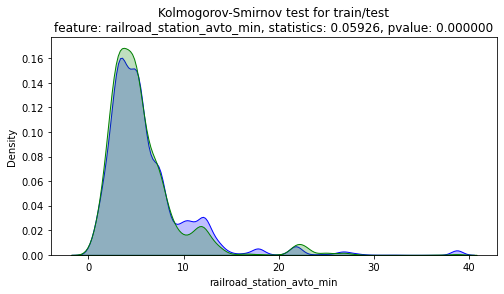

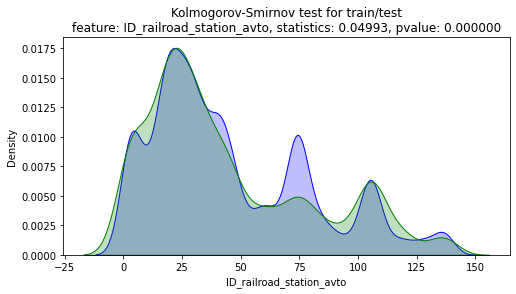

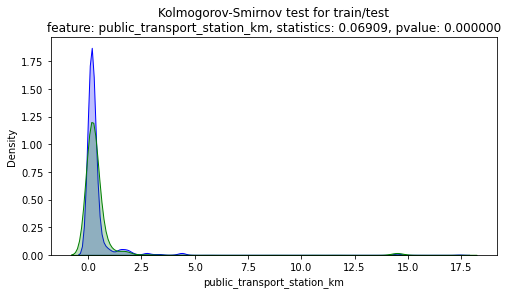

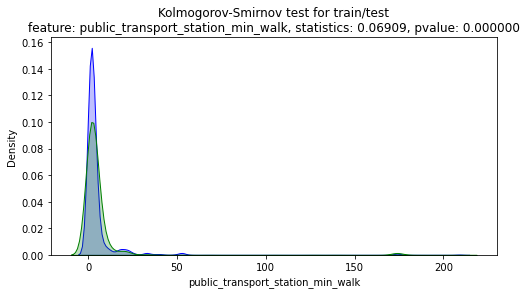

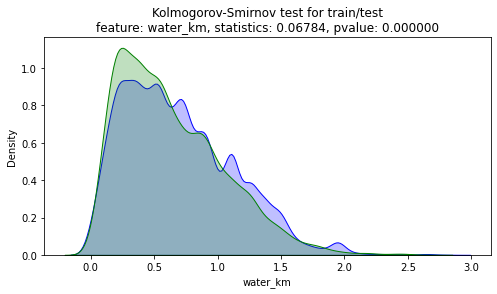

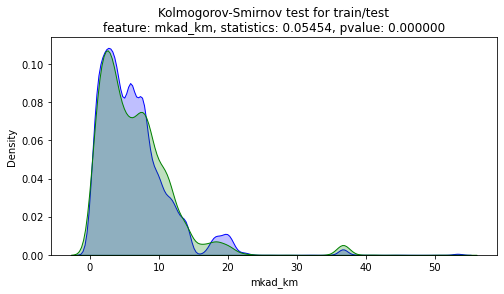

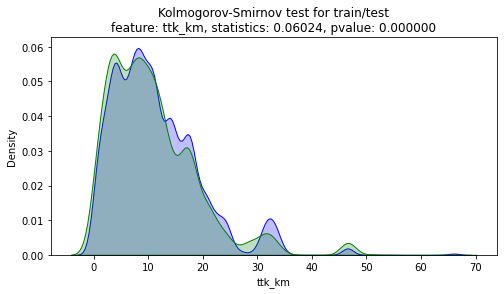

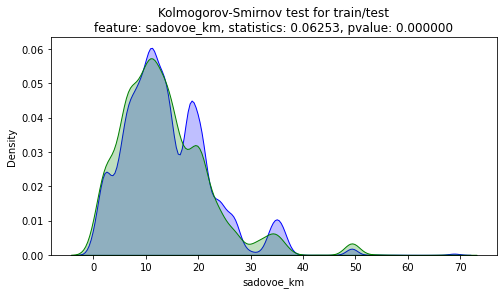

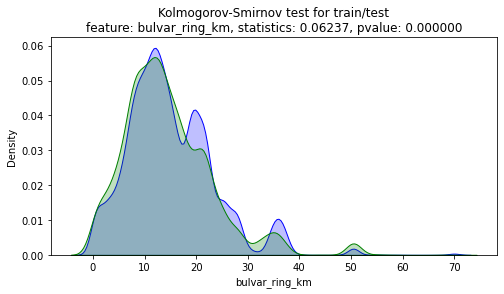

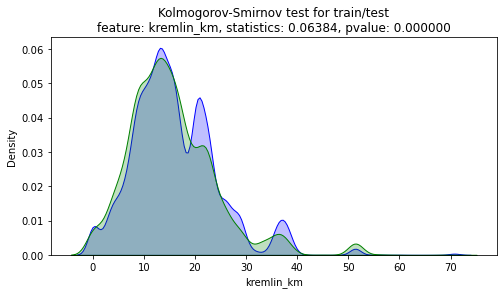

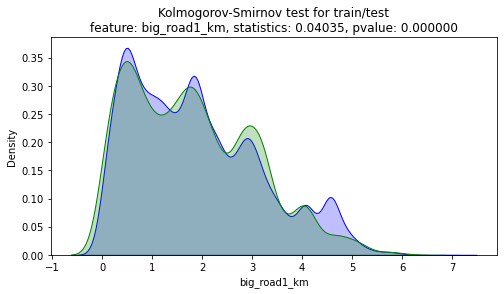

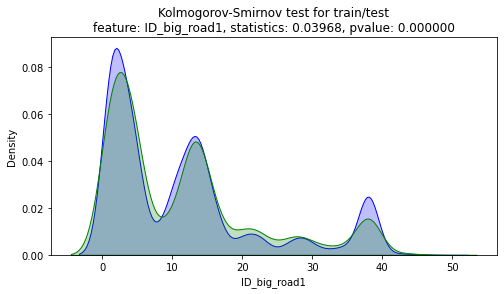

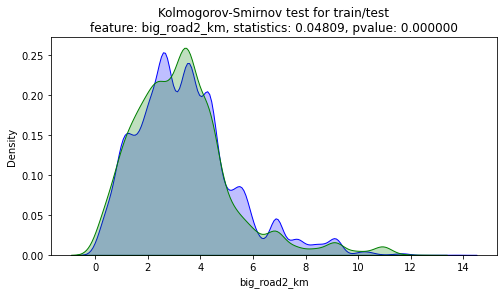

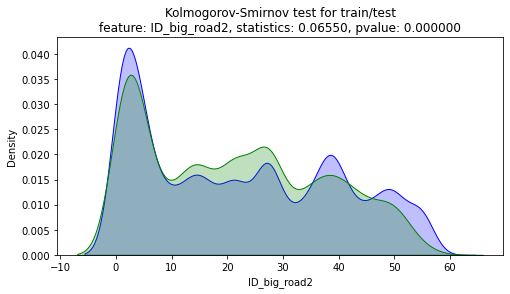

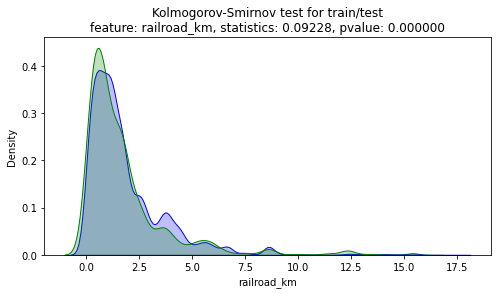

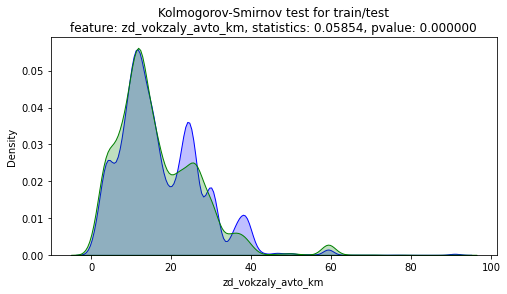

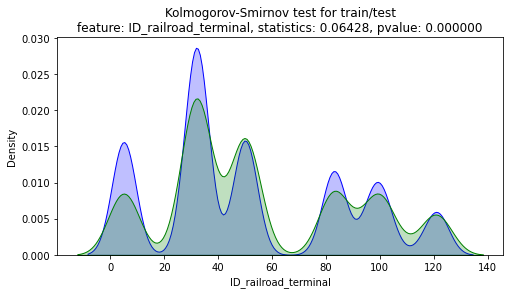

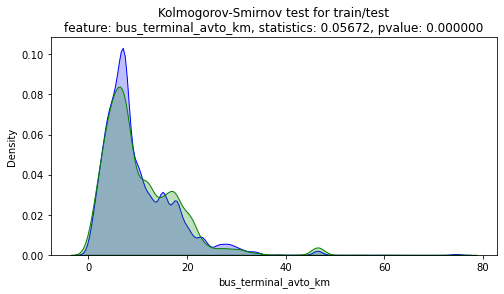

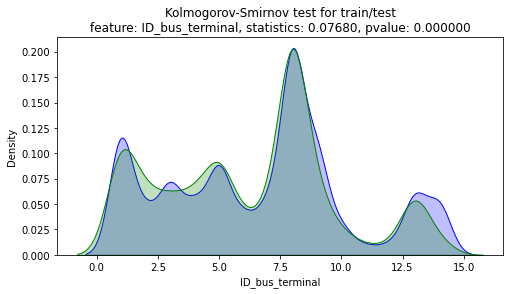

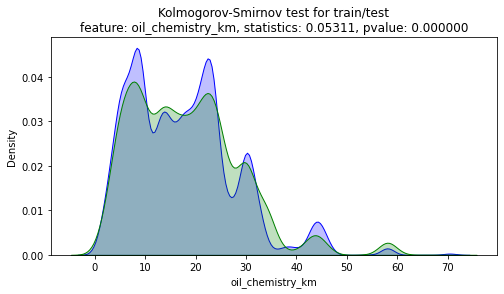

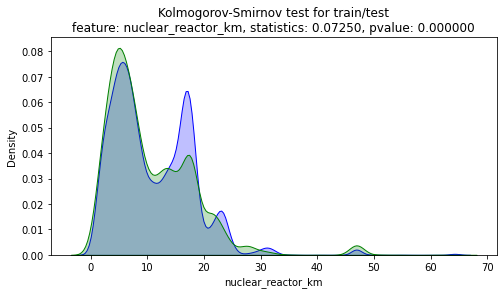

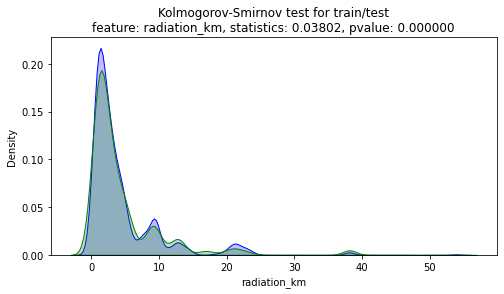

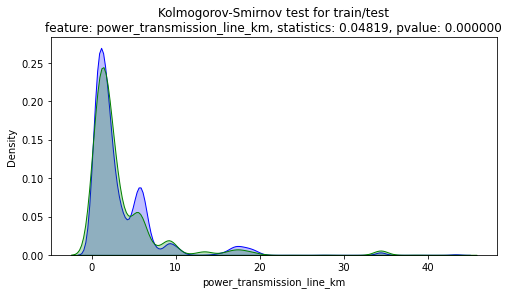

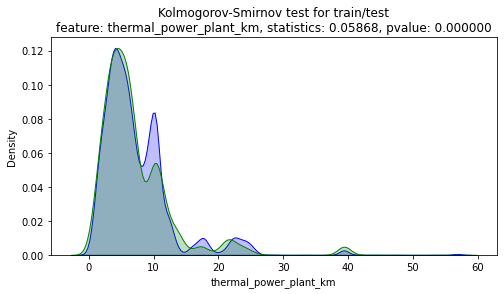

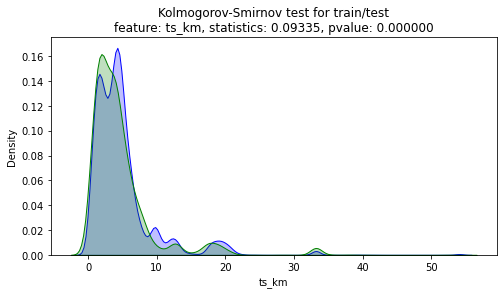

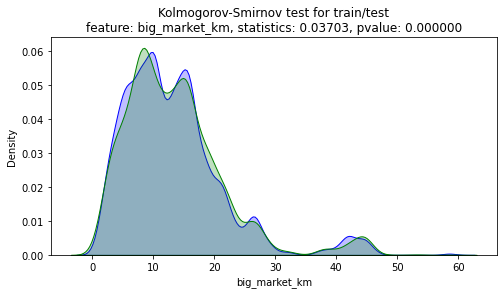

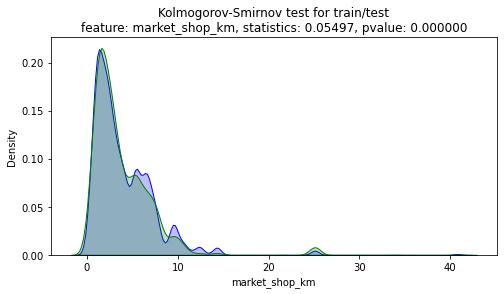

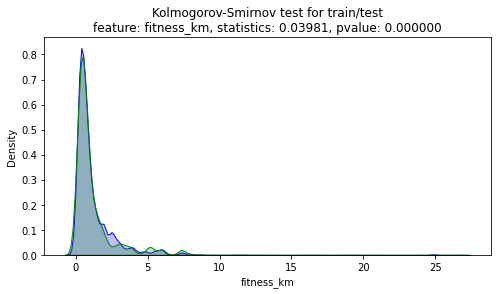

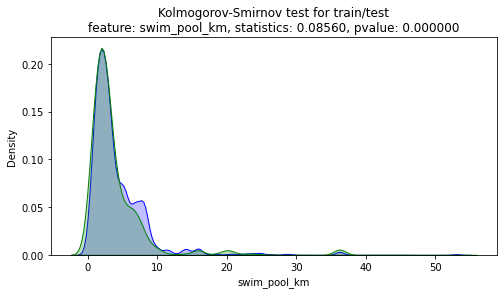

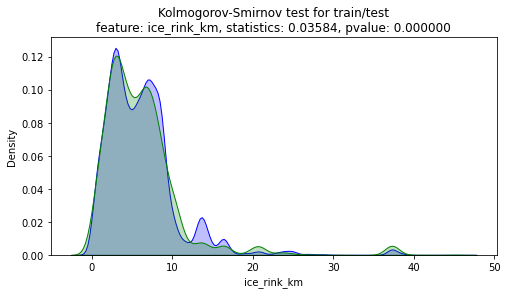

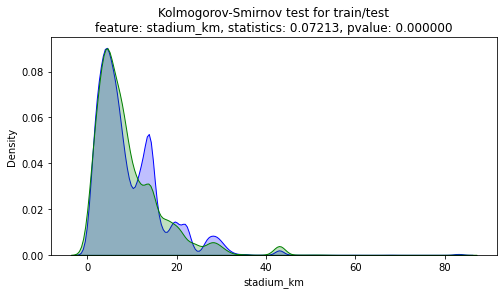

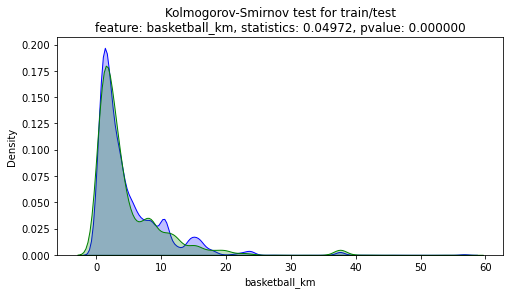

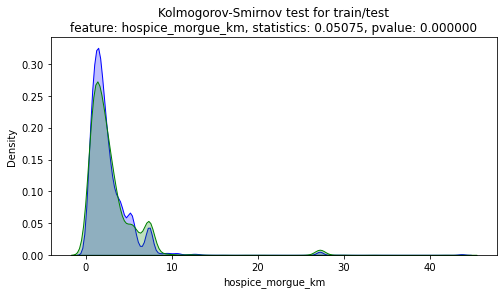

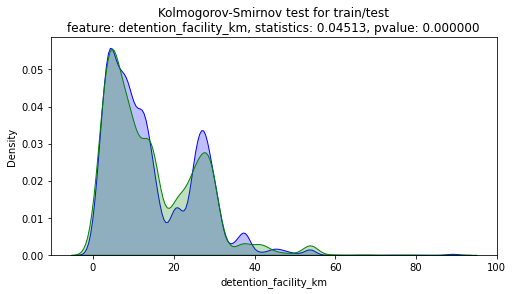

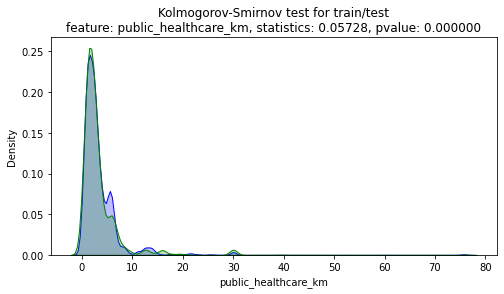

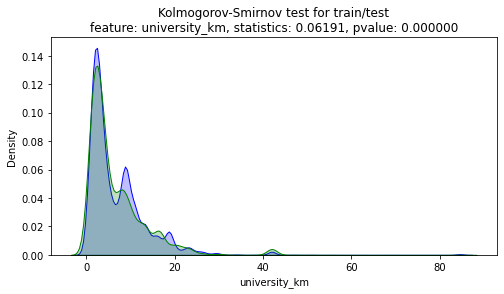

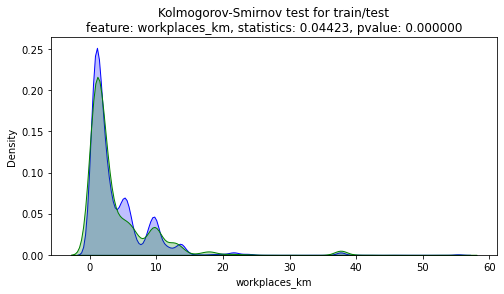

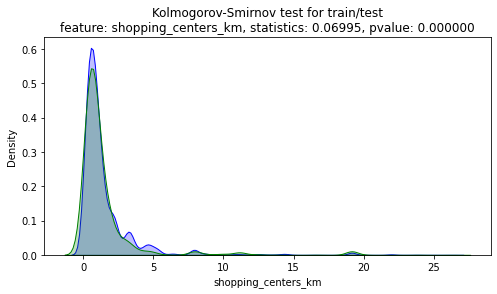

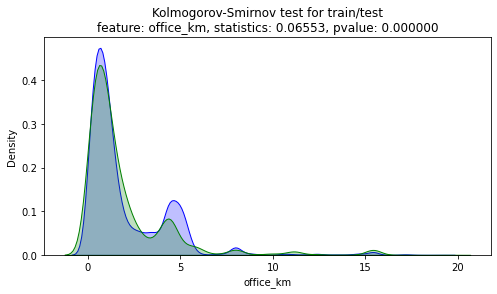

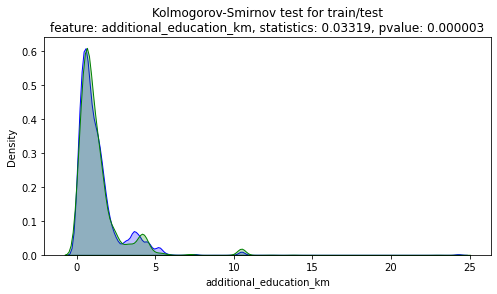

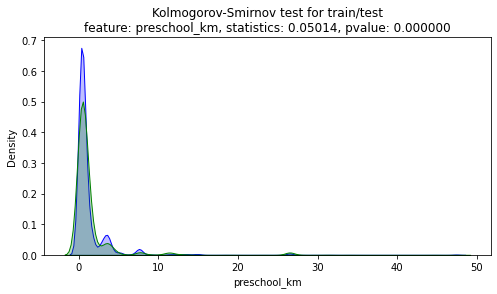

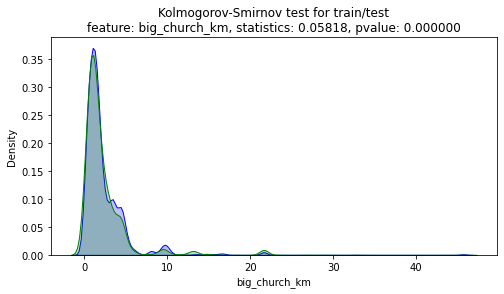

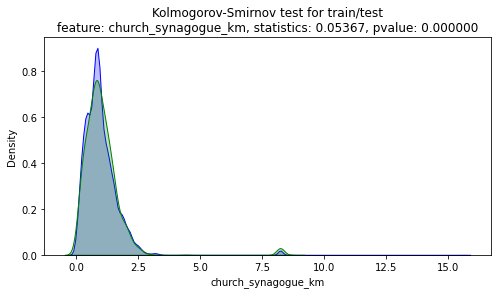

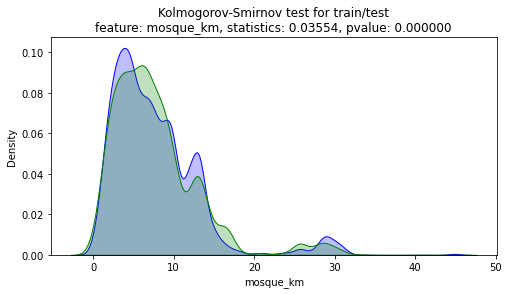

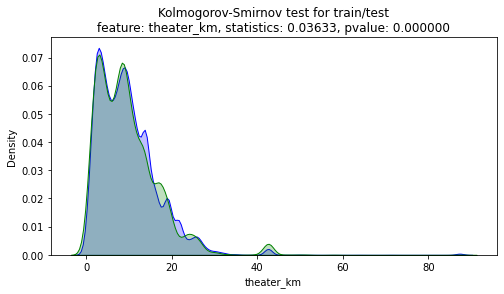

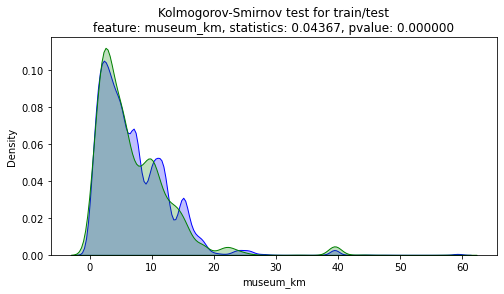

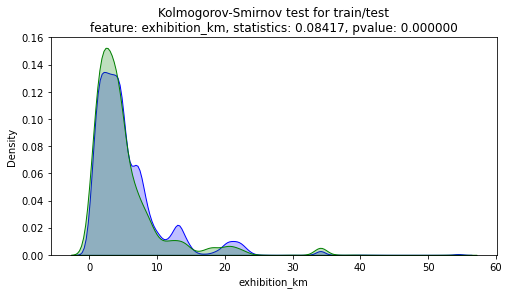

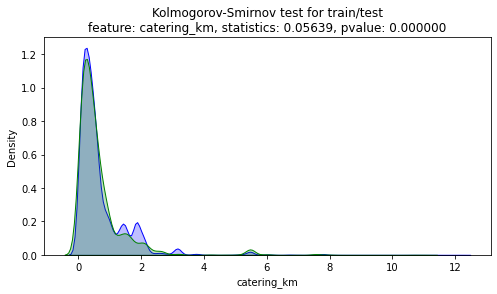

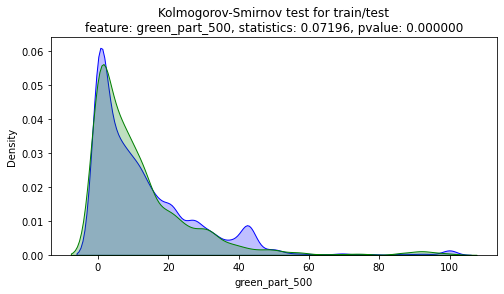

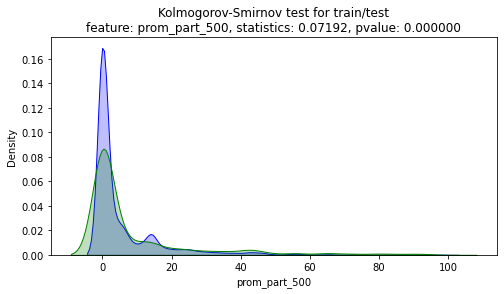

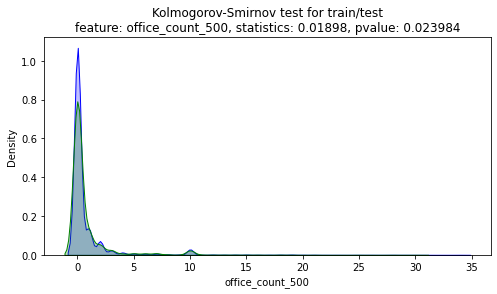

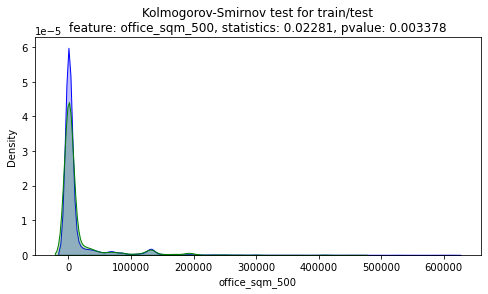

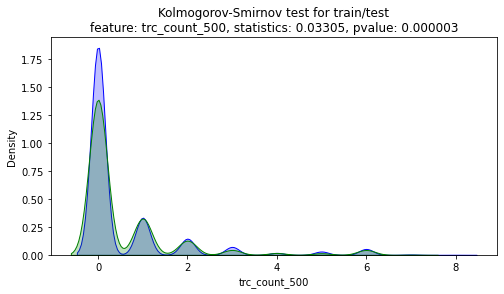

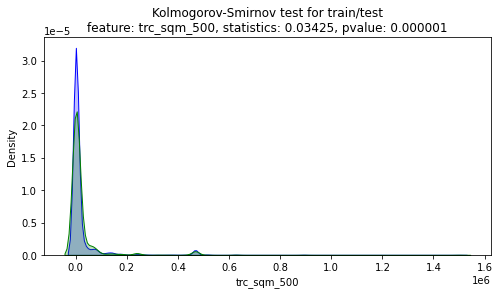

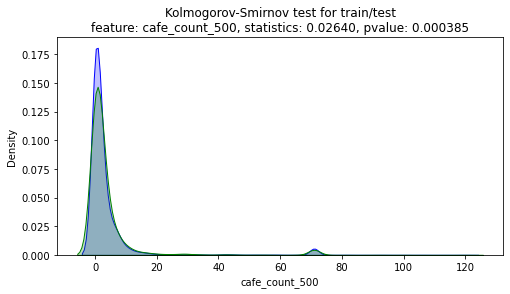

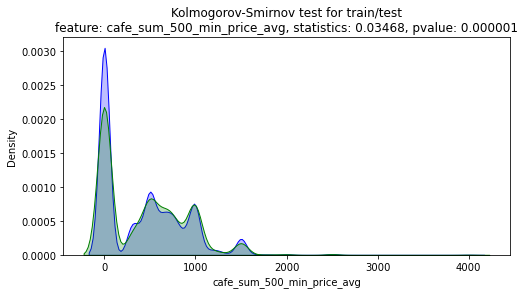

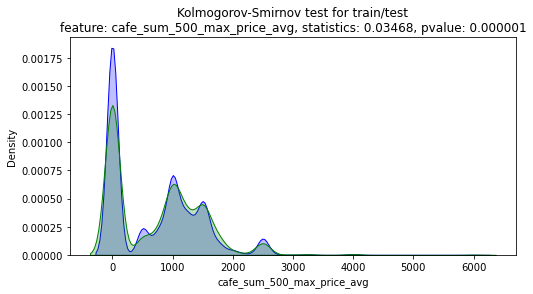

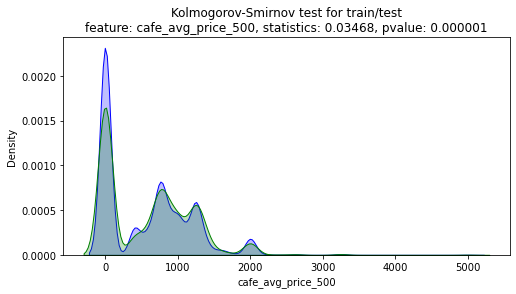

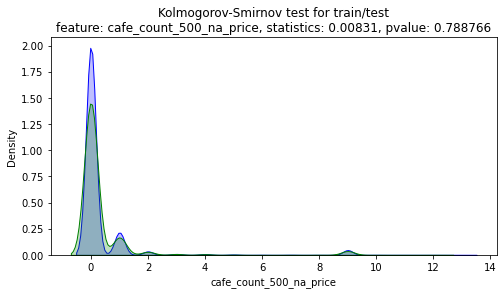

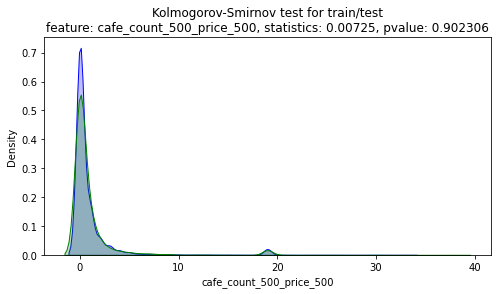

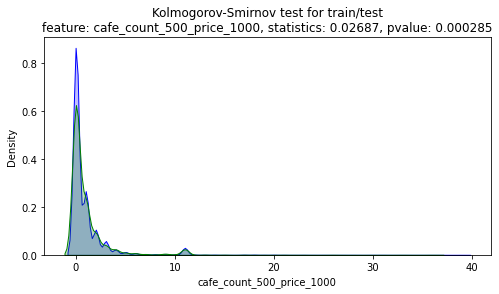

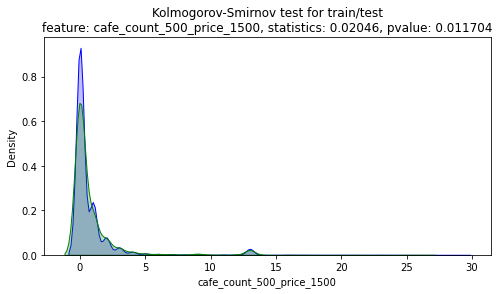

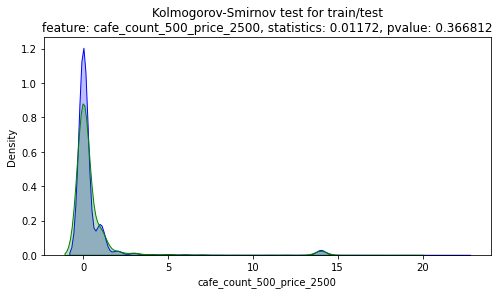

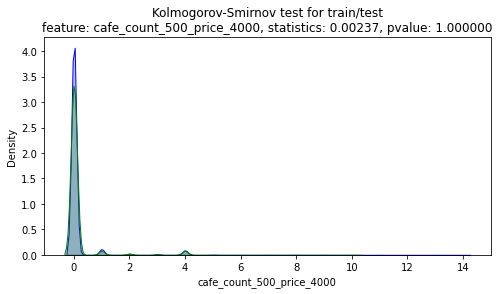

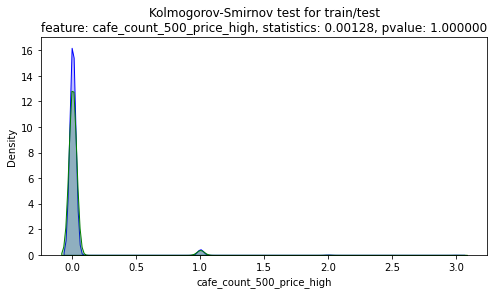

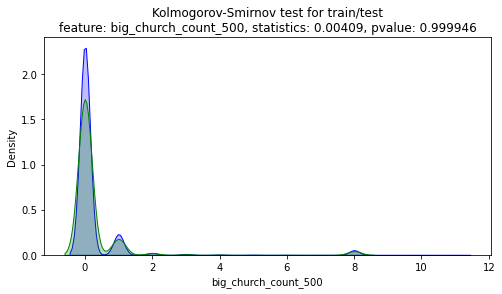

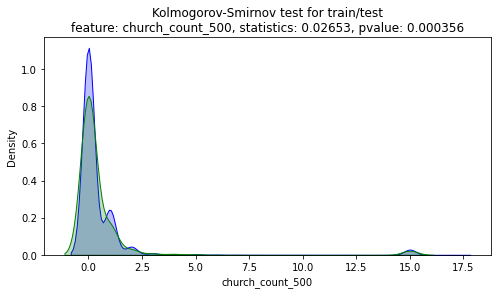

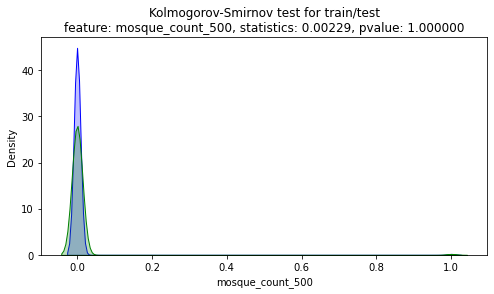

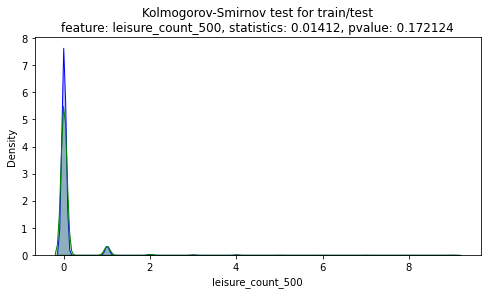

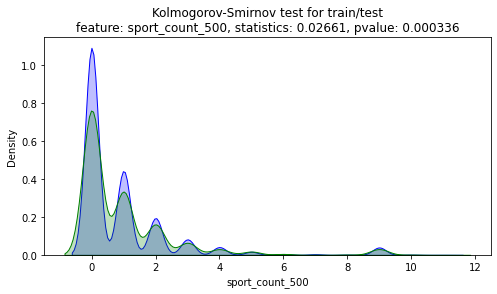

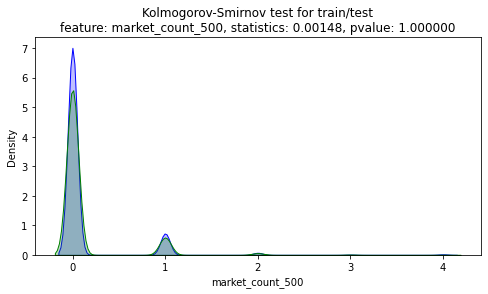

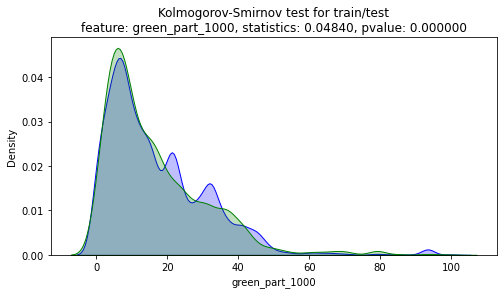

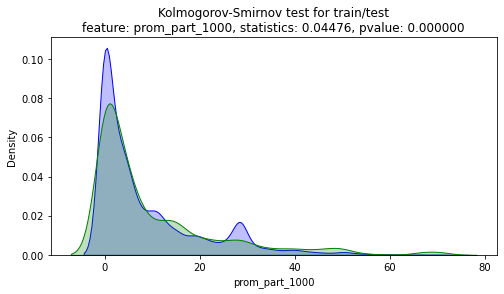

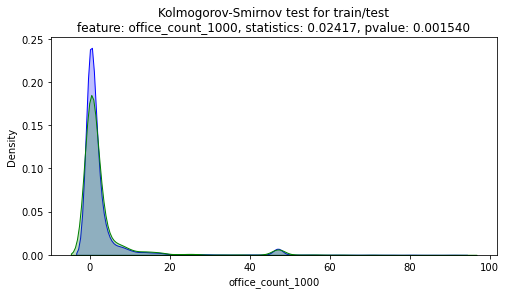

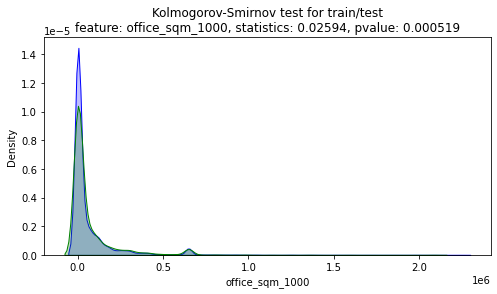

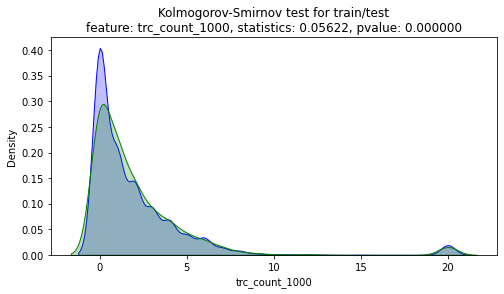

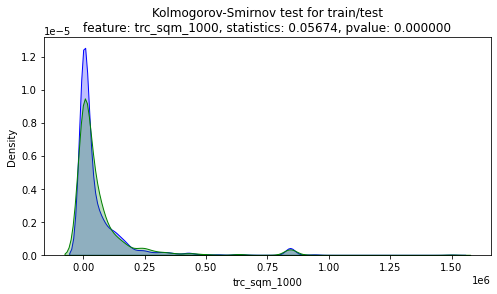

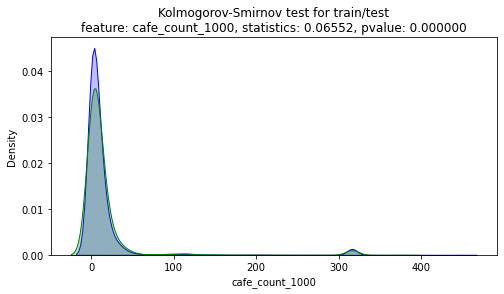

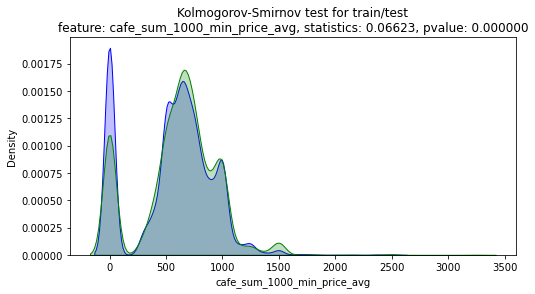

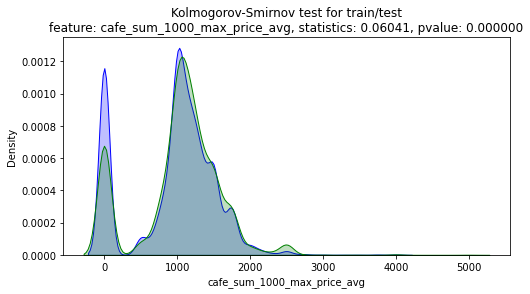

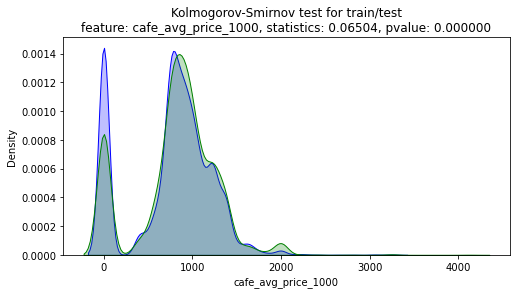

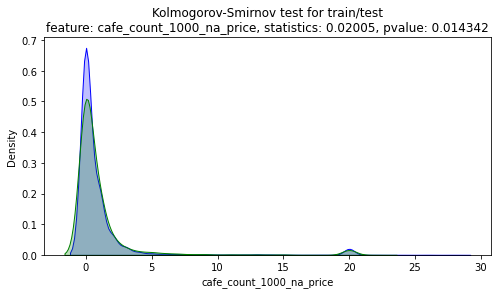

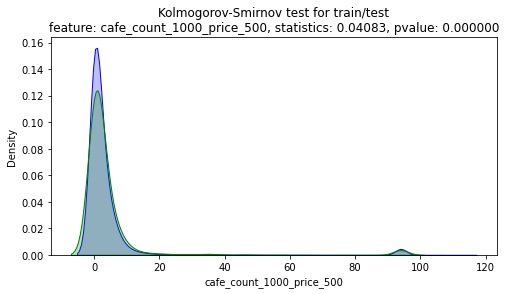

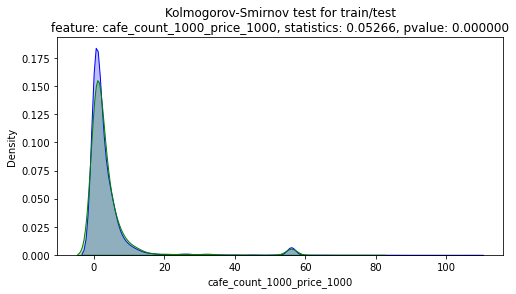

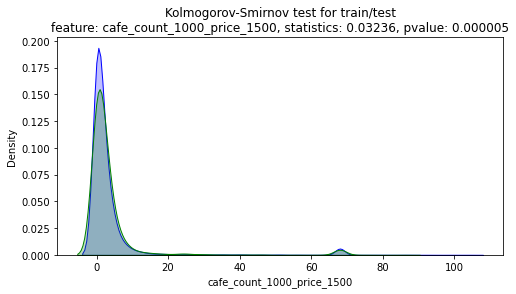

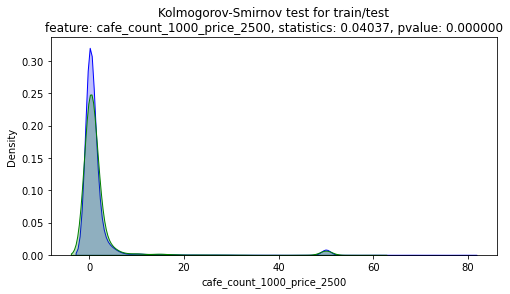

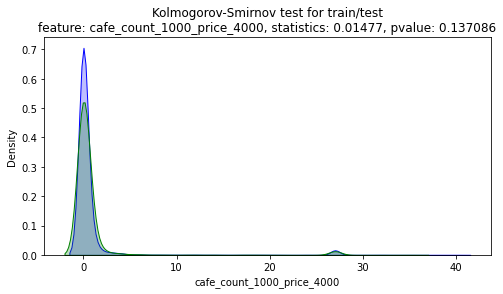

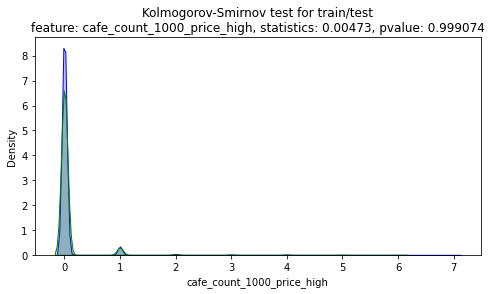

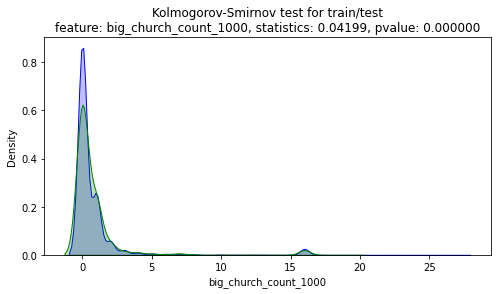

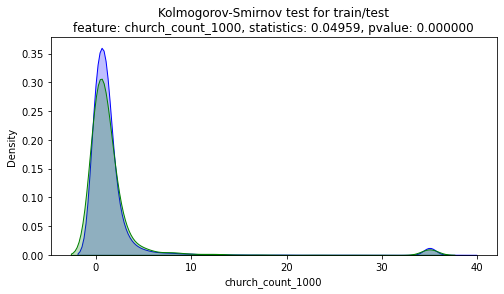

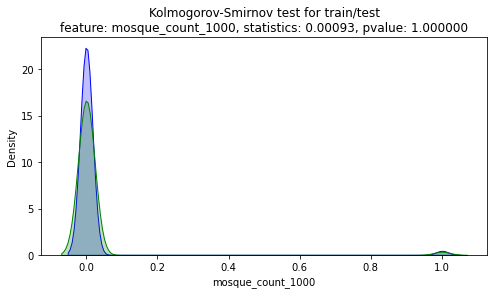

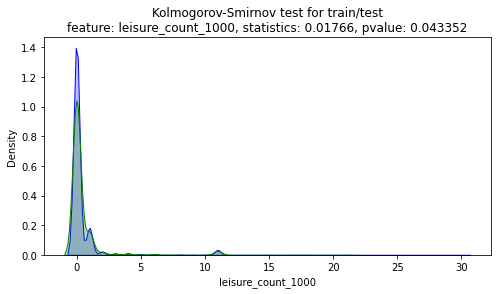

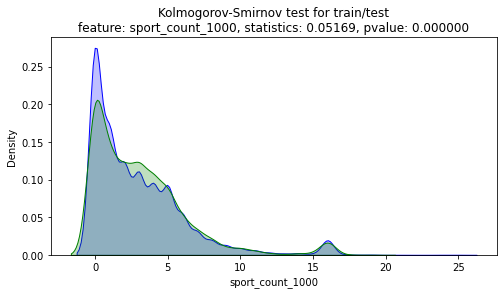

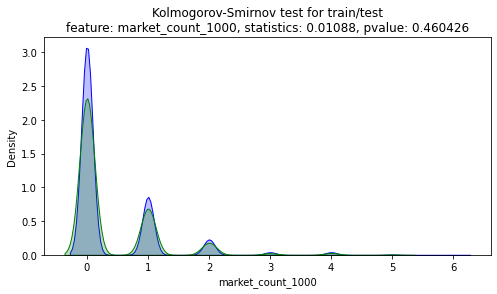

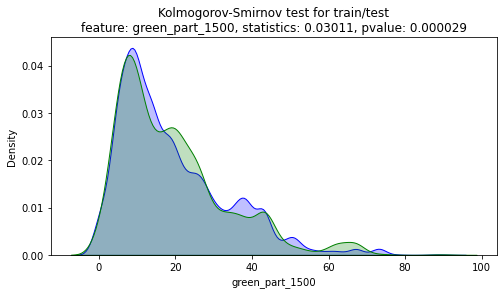

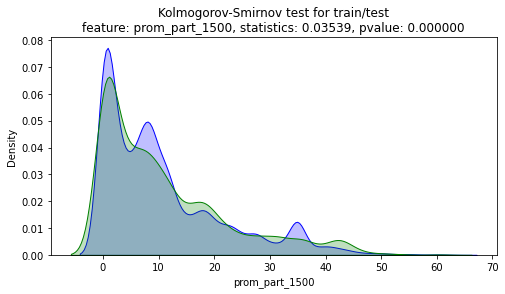

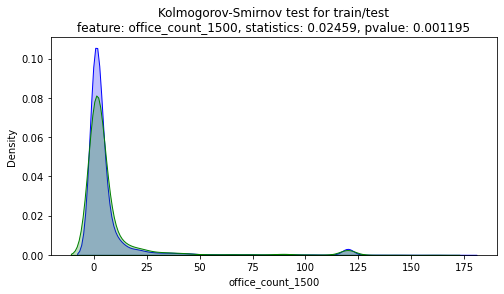

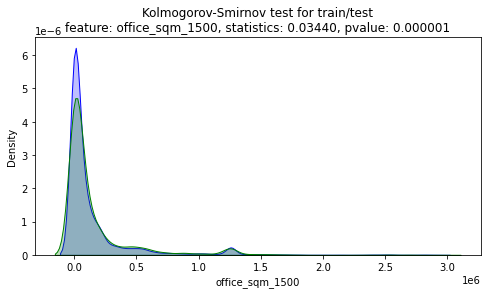

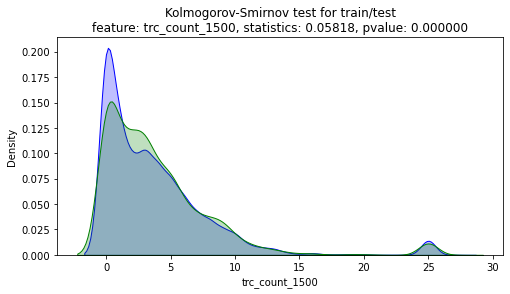

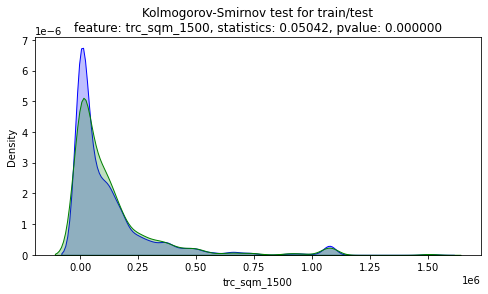

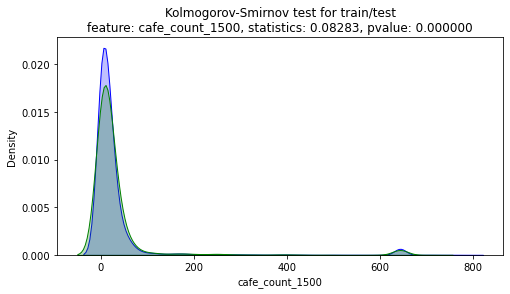

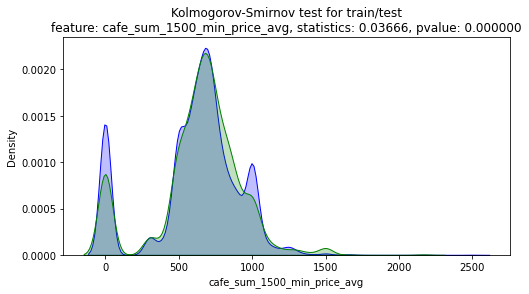

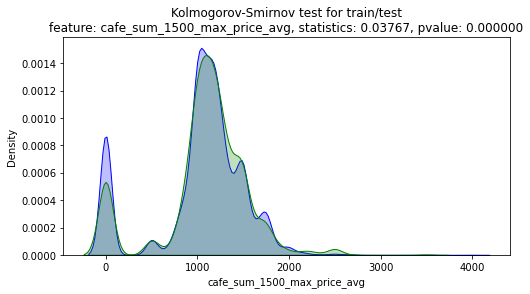

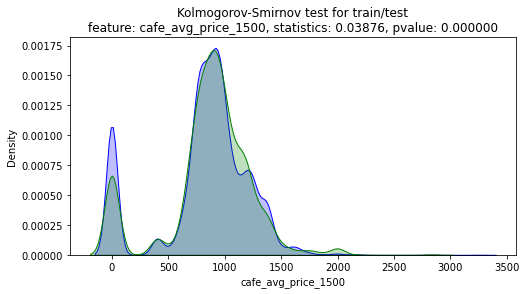

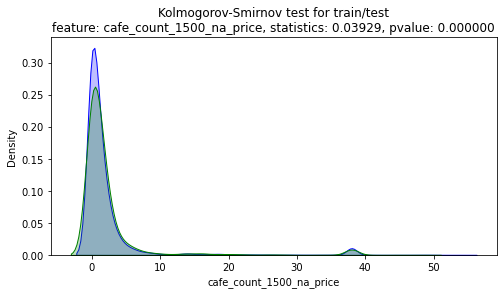

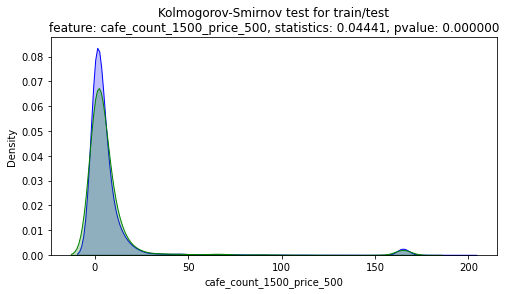

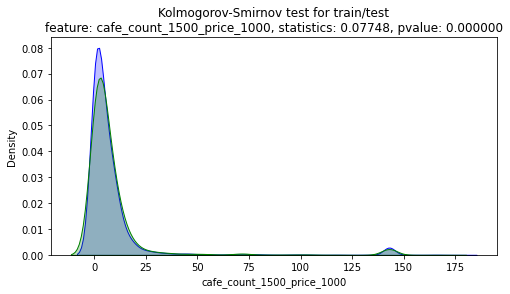

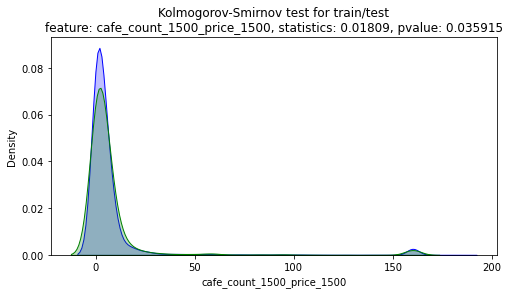

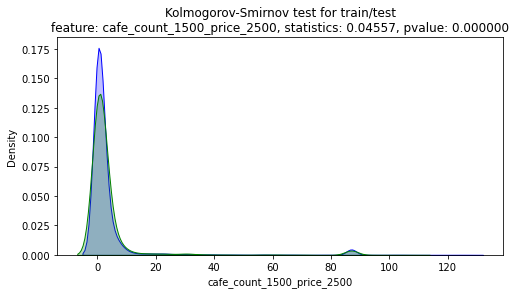

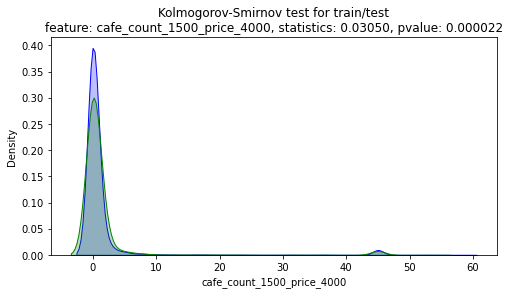

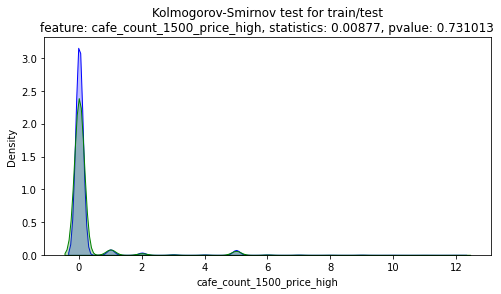

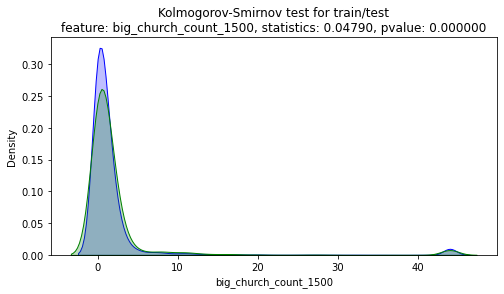

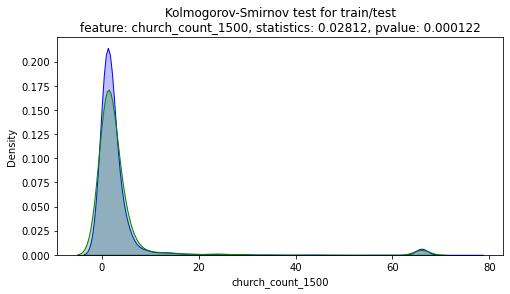

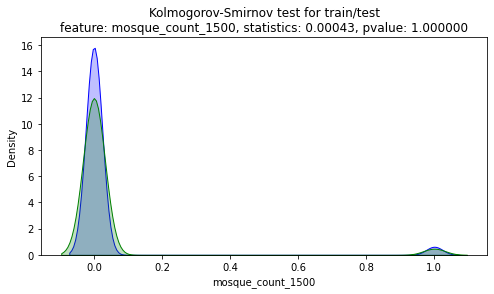

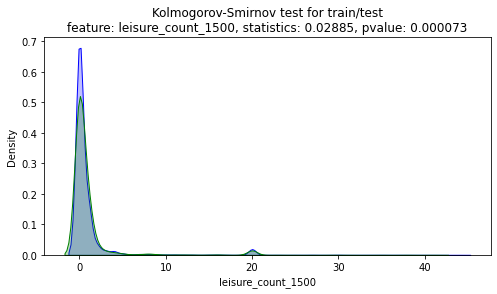

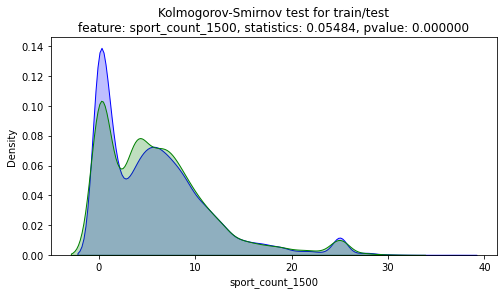

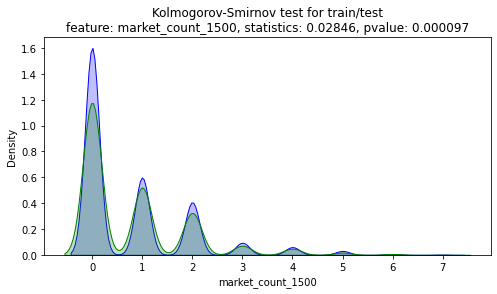

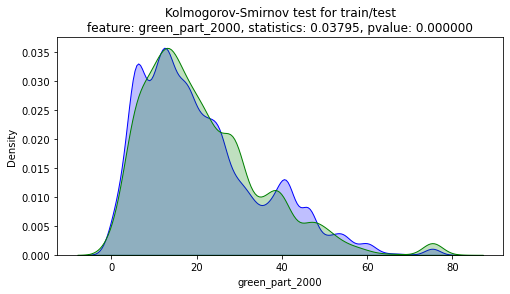

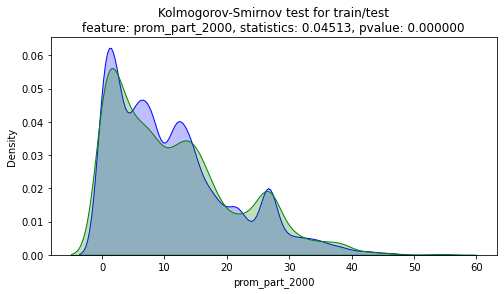

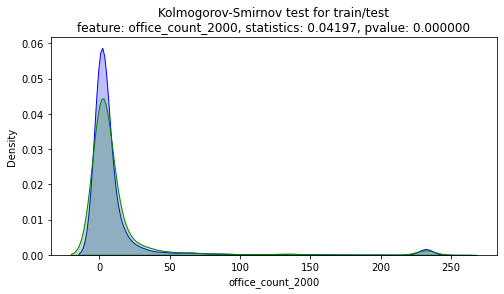

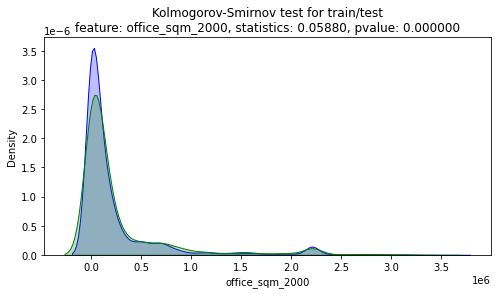

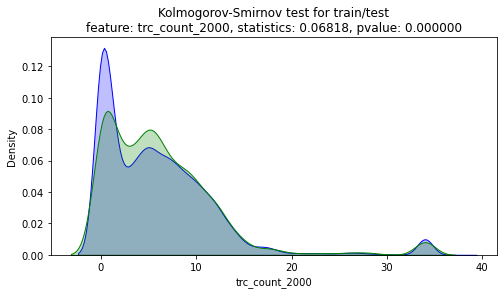

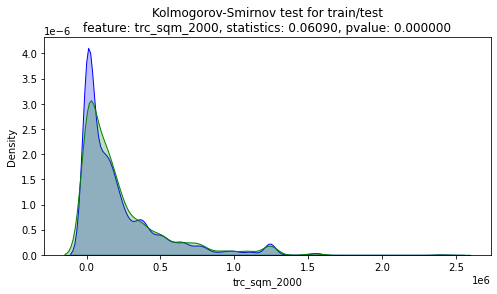

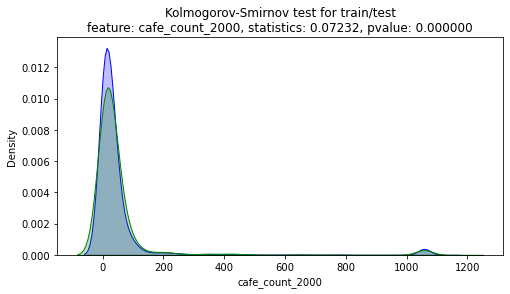

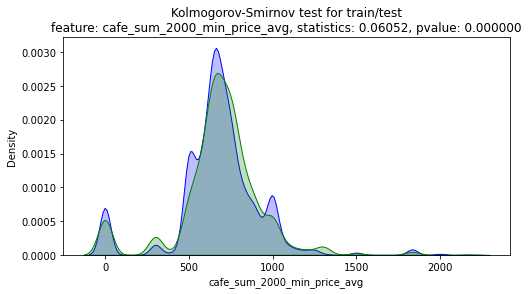

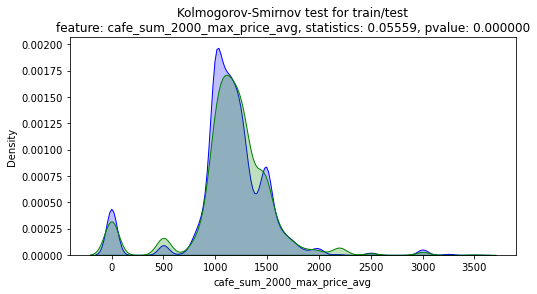

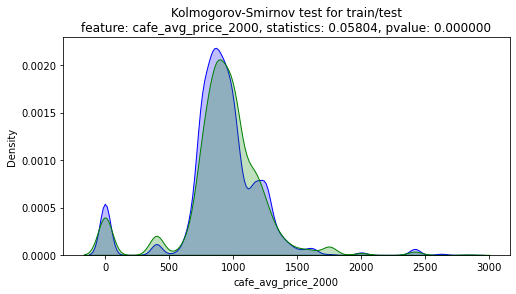

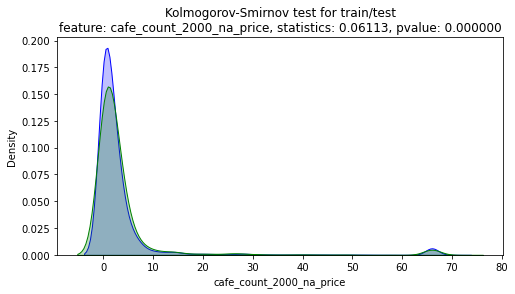

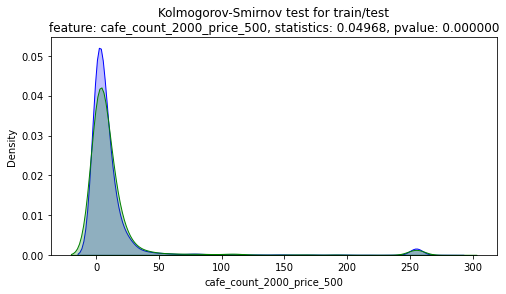

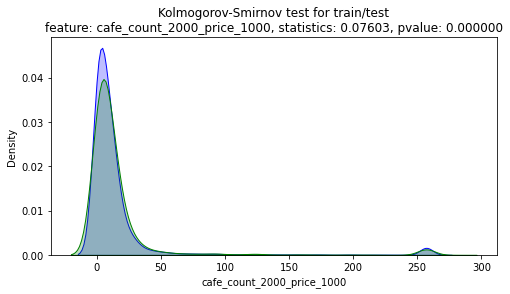

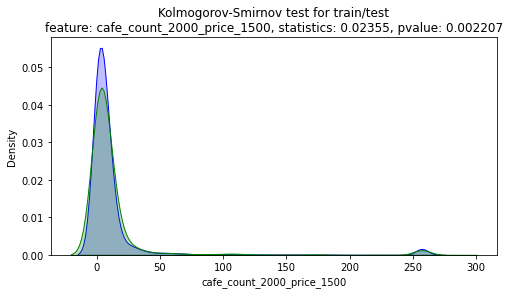

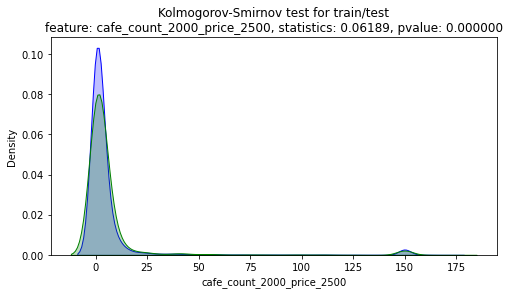

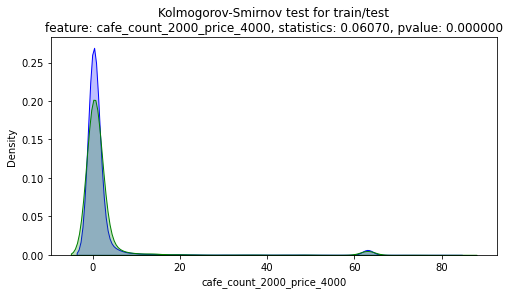

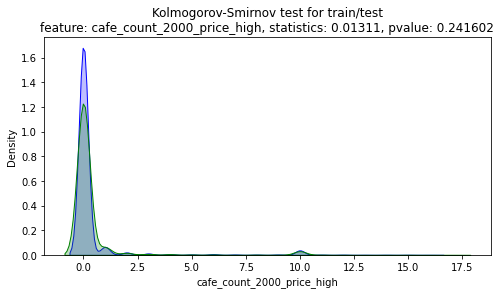

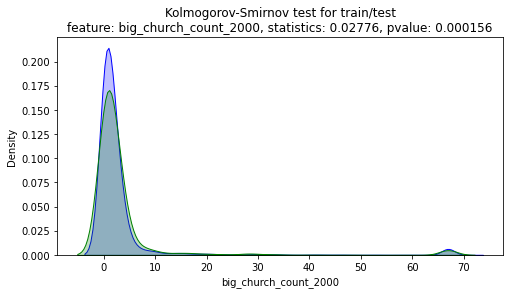

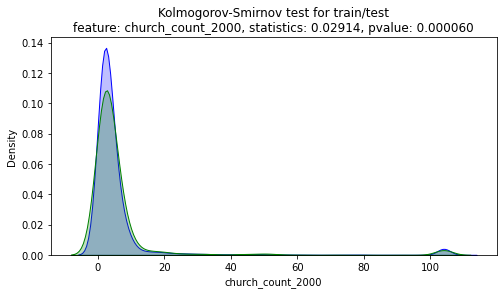

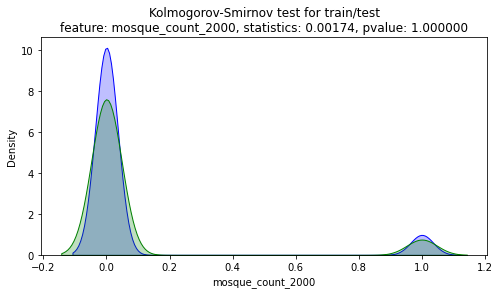

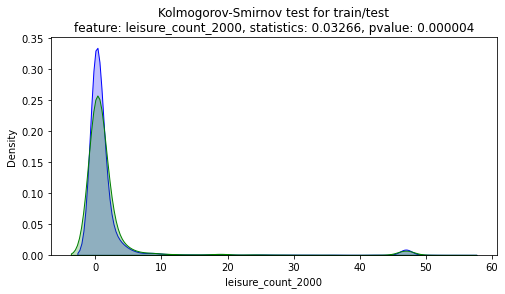

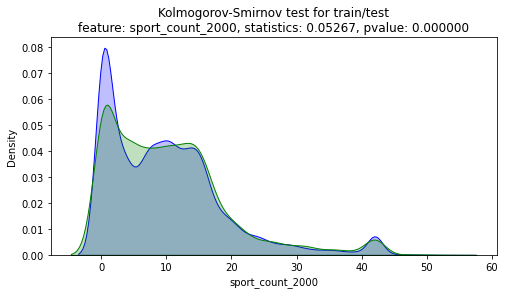

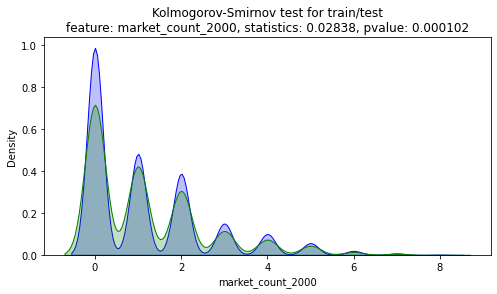

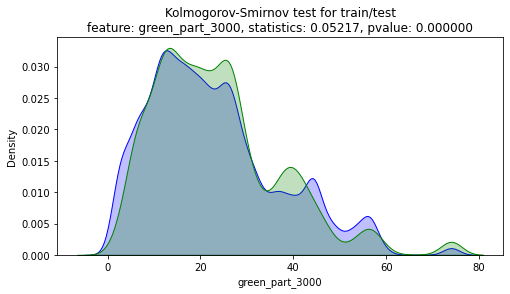

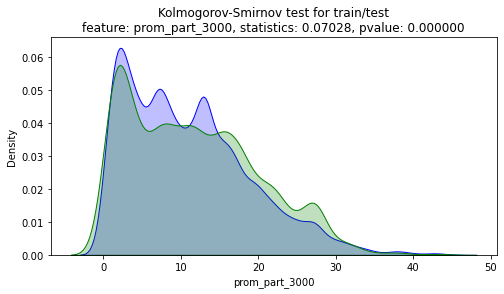

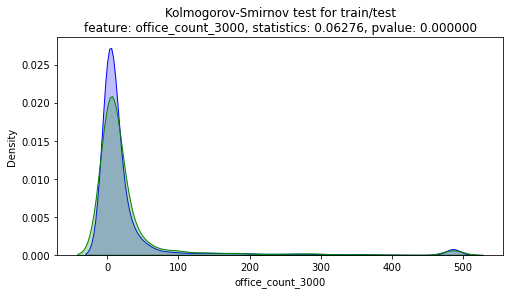

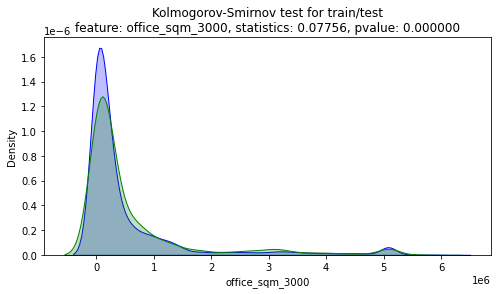

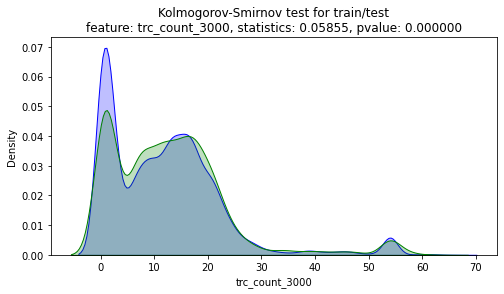

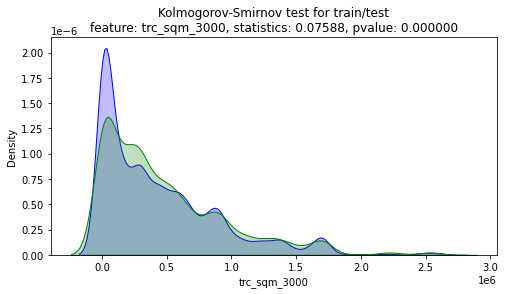

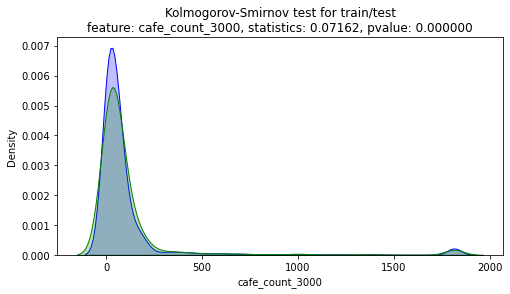

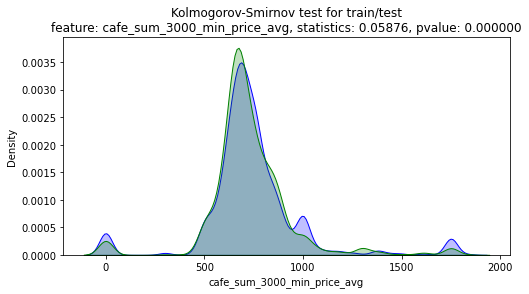

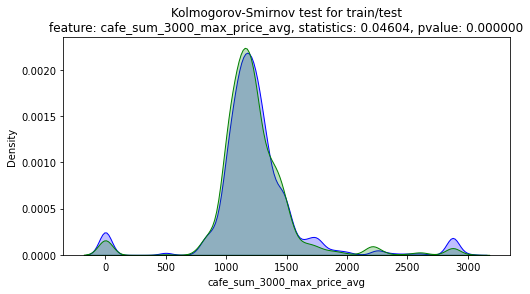

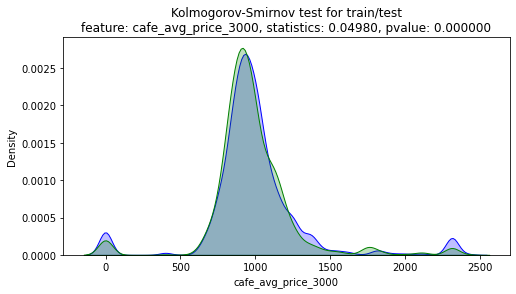

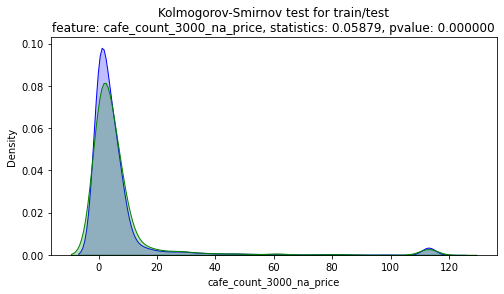

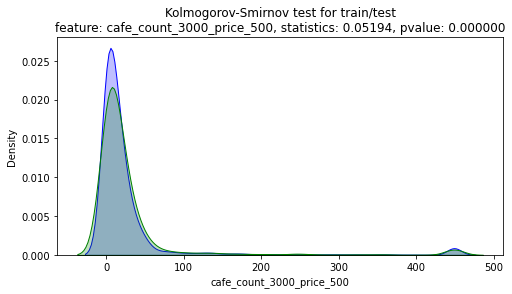

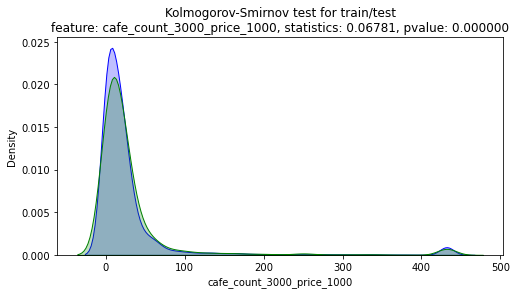

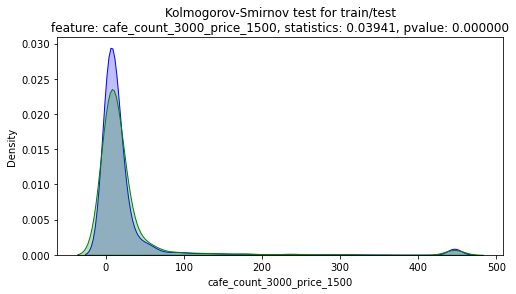

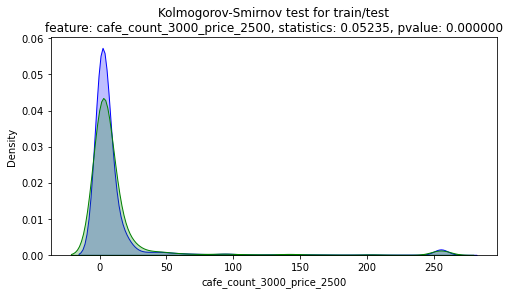

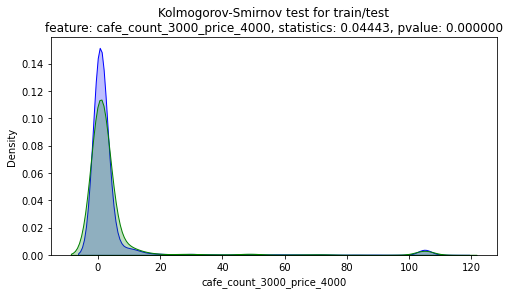

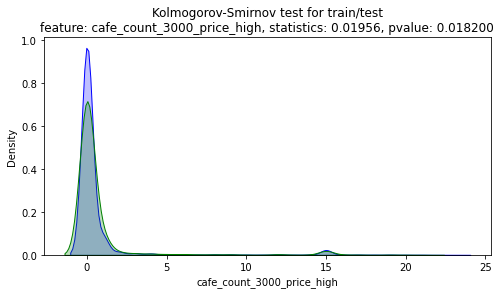

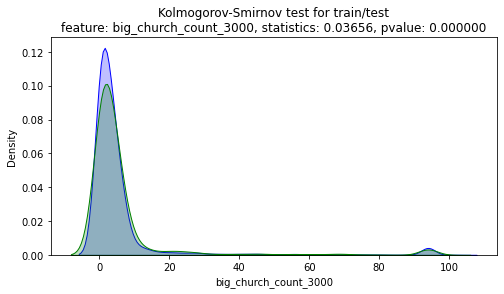

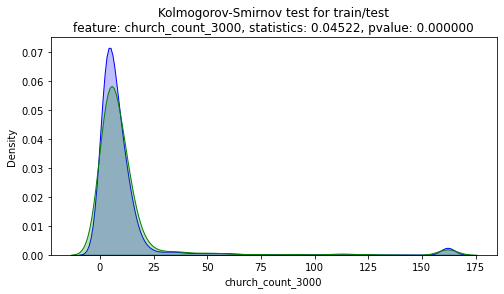

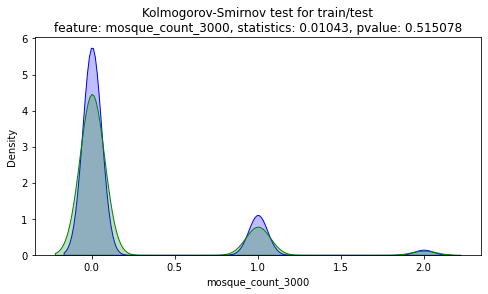

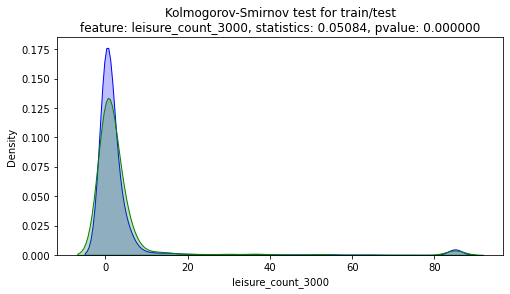

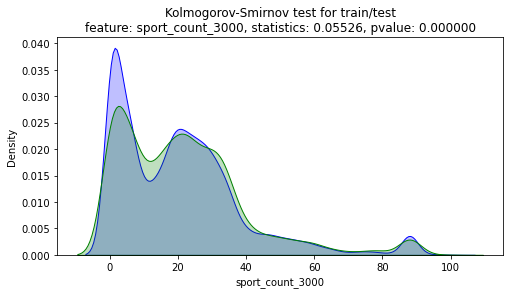

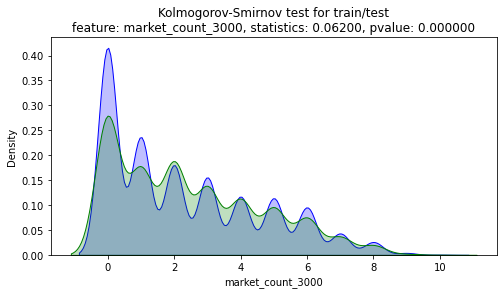

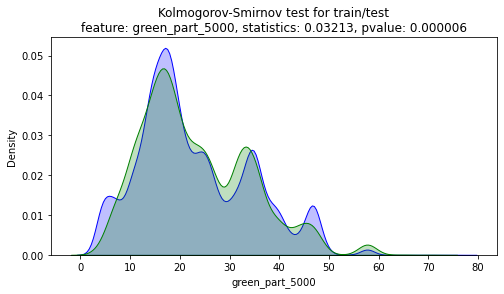

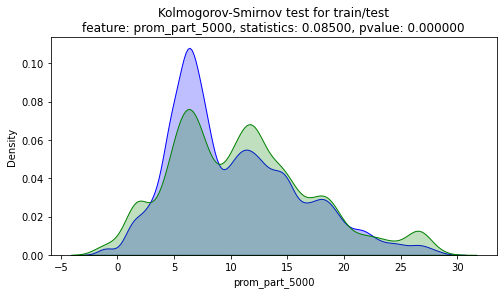

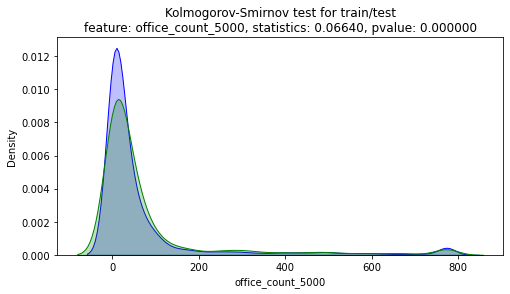

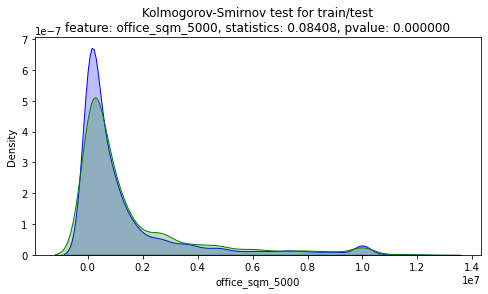

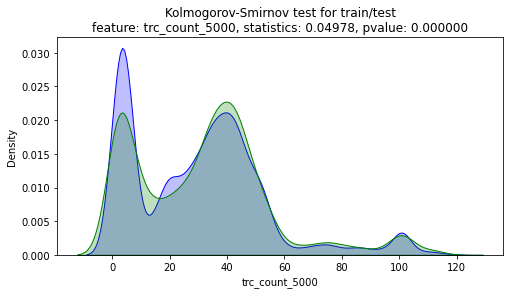

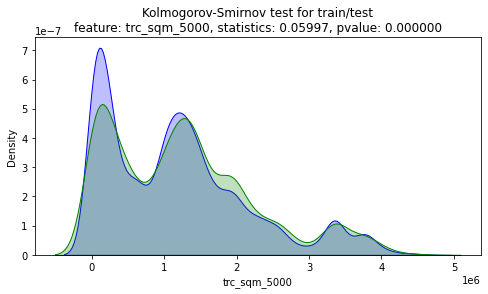

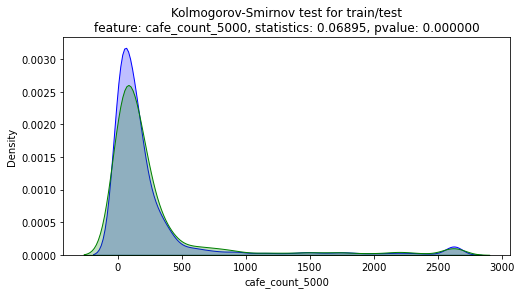

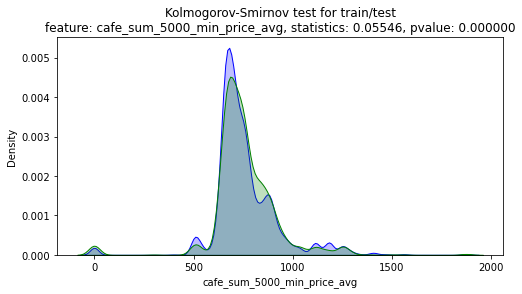

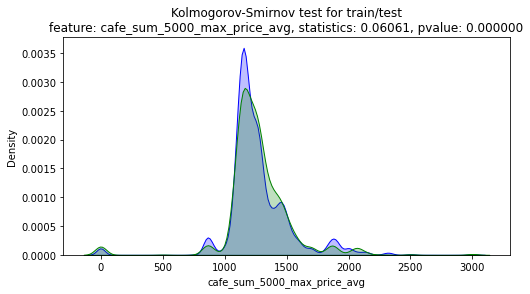

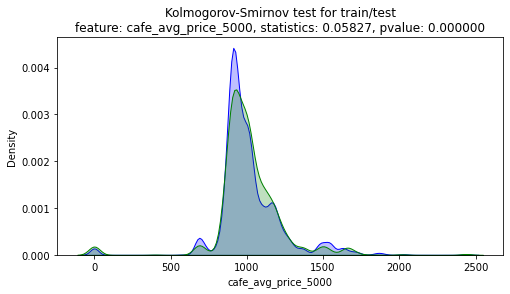

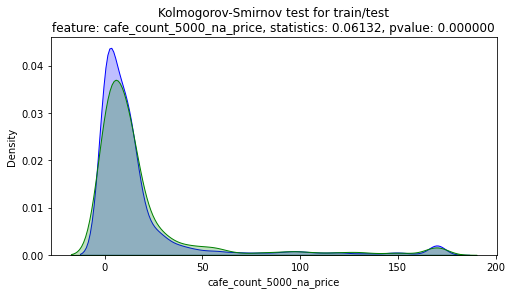

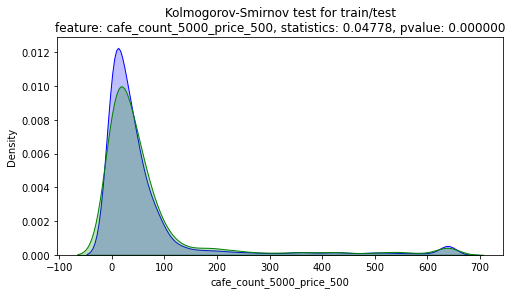

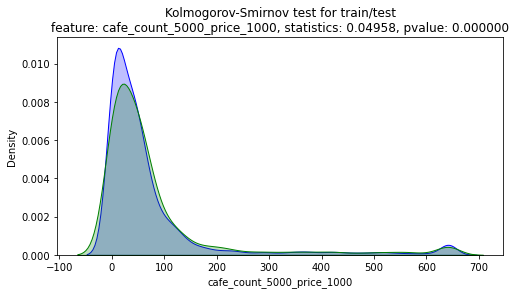

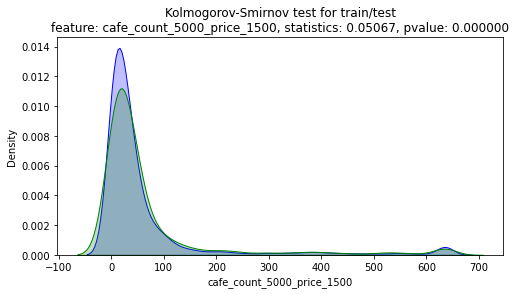

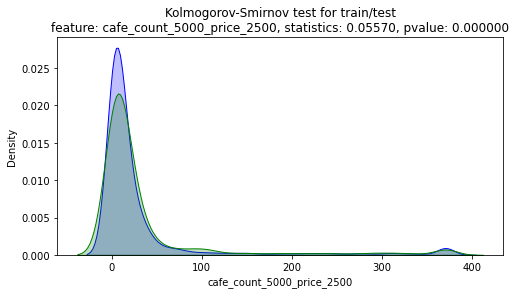

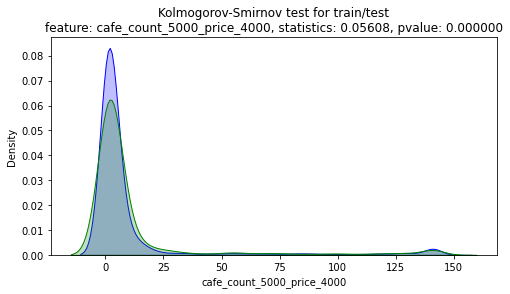

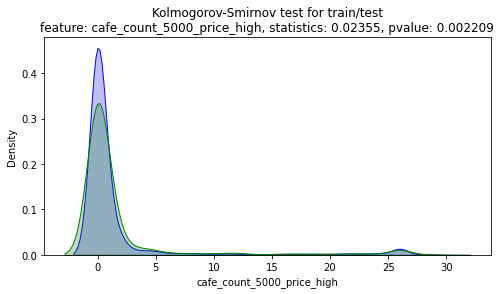

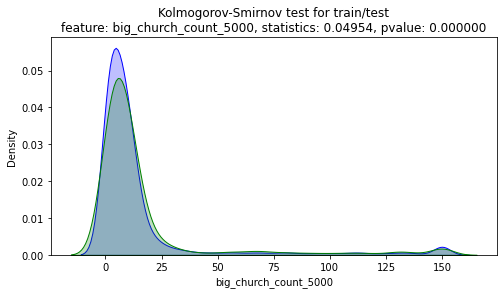

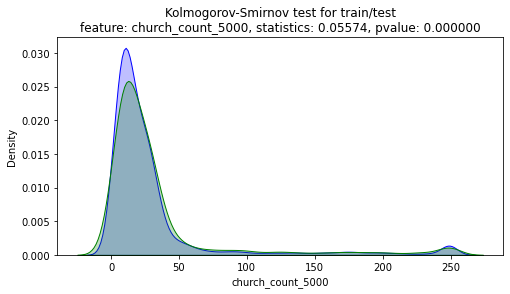

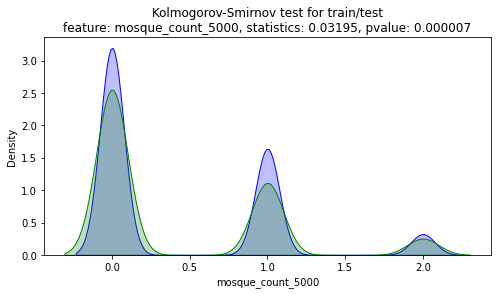

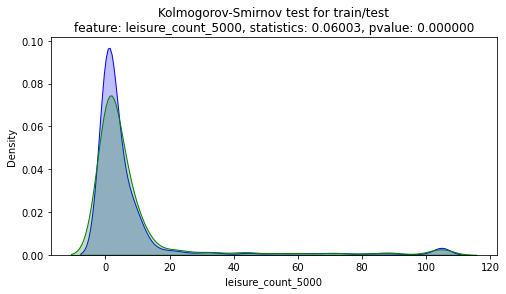

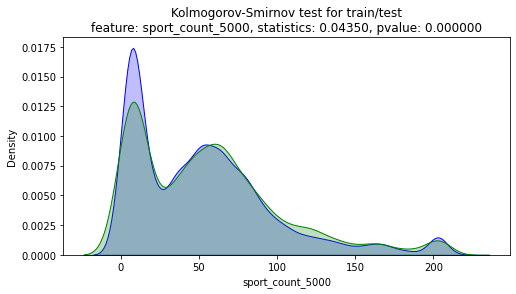

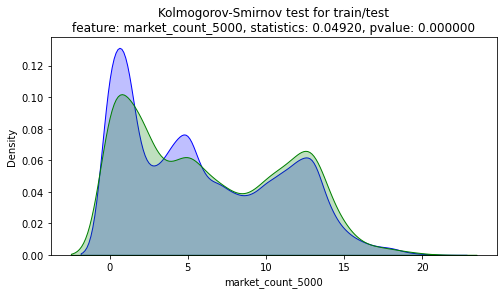

C:\Users\004567\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\004567\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


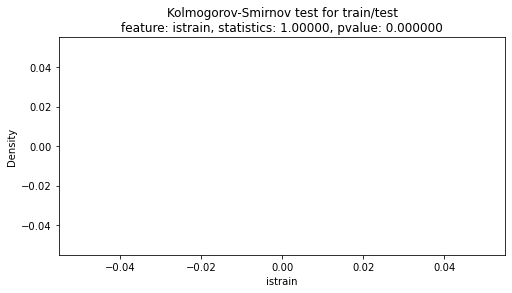

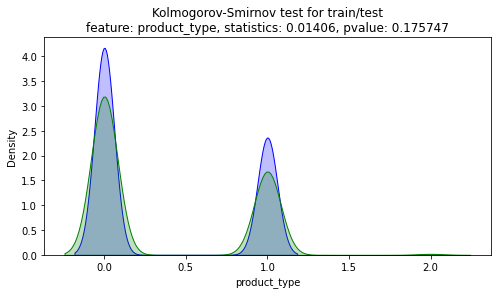

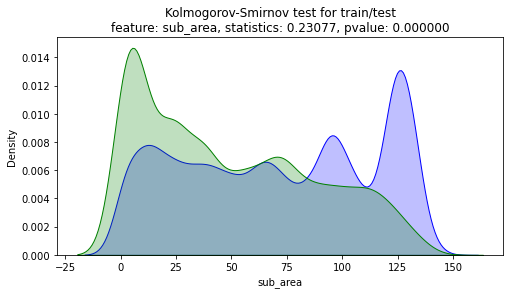

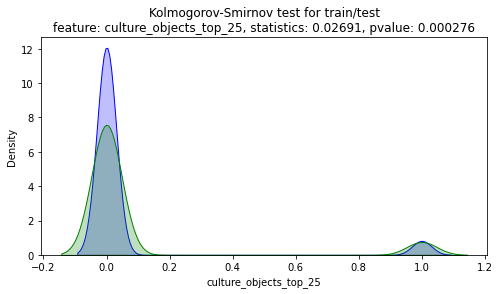

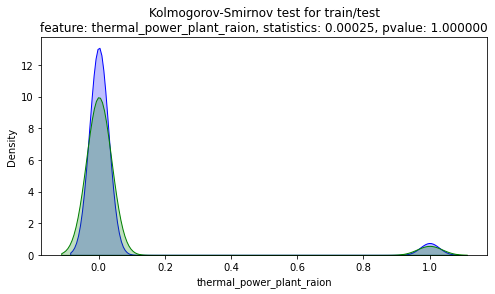

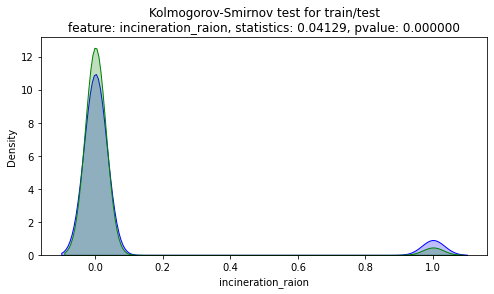

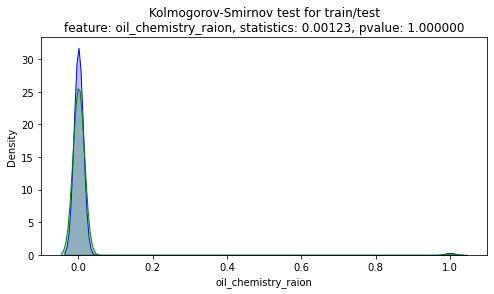

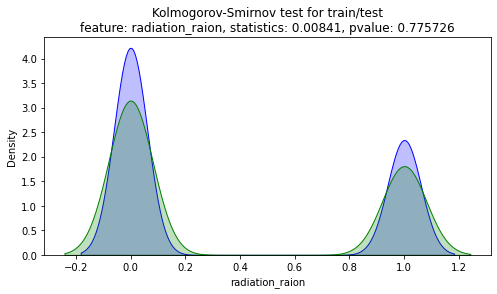

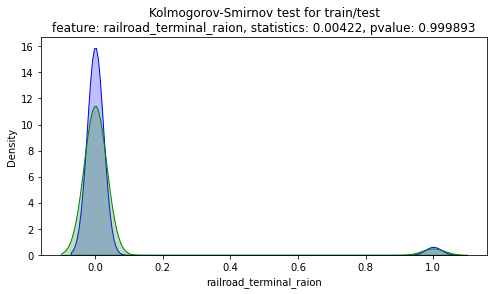

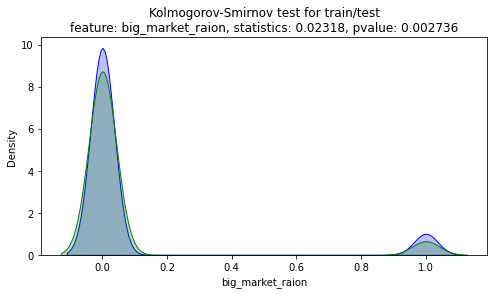

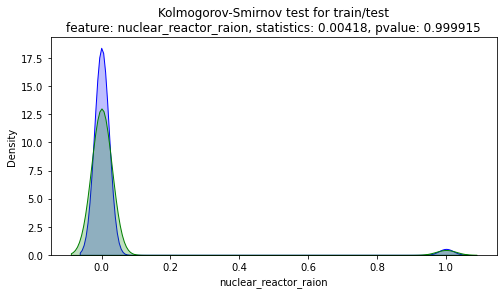

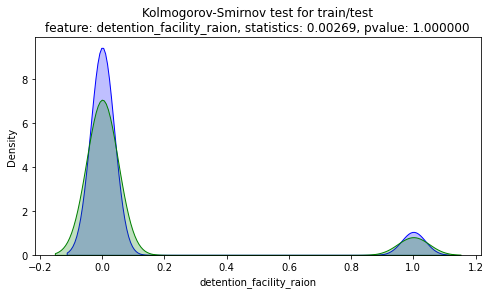

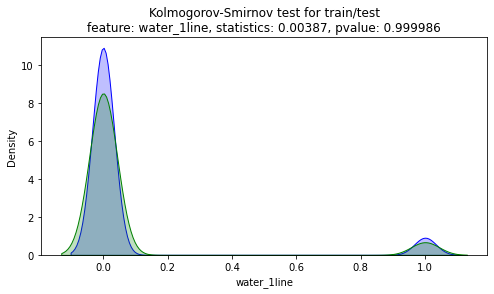

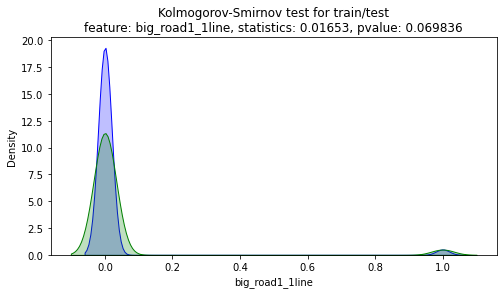

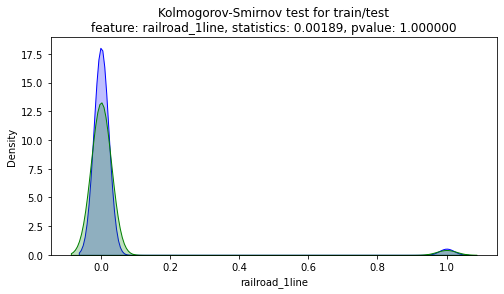

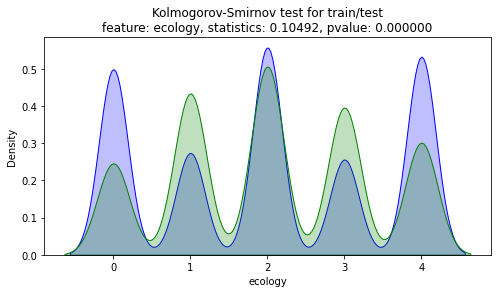

In [103]:
hypothesisnotrejected = []
hypothesisrejected = []

for col in xtrain.columns:
    statistic, pvalue = stats.ks_2samp(xtrain[col], xtest[col])
    if pvalue>=statistic:
        hypothesisnotrejected.append(col)
    if pvalue<statistic:
        hypothesisrejected.append(col)
        
    plt.figure(figsize=(8,4))
    plt.title("Kolmogorov-Smirnov test for train/test\n"
              "feature: {}, statistics: {:.5f}, pvalue: {:5f}".format(col, statistic, pvalue))
    sns.kdeplot(xtrain[col], color='blue', shade=True, label='Train')
    sns.kdeplot(xtest[col], color='green', shade=True, label='Test')

    plt.show()

In [104]:
len(hypothesisnotrejected), len(hypothesisrejected)

(36, 254)

As we can see, 36 features successfully passed Kolmogorov-Smirnov test. __We can reject null hypothesis that those features in train and test sets came from the same distribution__. 254 feature hasn't passed this test and probably require our attention.

In [107]:
xtrain.shape

(30471, 290)

# Solutions

# Method 1: Automated Feature Selection

As we mentioned before, ROC-AUC scores of 0.8 or more would alert you that the test set is
peculiar and quite distinguishable from the training data.


If distributions of the features from the train and test data are similar, we expect the adversarial classifier to be as good as random guesses. However, if the adversarial classifier can distinguish between training and test data well (i.e. AUC score ≫ 50%), the top features from the adversarial classifier are potential candidates exhibiting concept drift between the train and test data. We can then exclude these features from model training.

Such feature selection can be automated by determining the
number of features to exclude based on the performance of adversarial classifier (e.g. AUC score) and raw feature importance values
(e.g. mean decrease impurity (MDI) in Decision Trees) as follows:

(1) Train an adversarial classifier that predicts P({train,test }|X)
to separate train and test.

(2) If the AUC score of the adversarial classifier is greater than
an AUC threshold θauc , remove features ranked within top
x% of remaining features in feature importance ranking and
with raw feature importance values higher than a threshold
θimp.

(3) Go back to Step 1, if AUC score greater than θauc .

(4) Once the adversarial AUC drops lower than θauc , train an
outcome classifier with the selected features and original
target variable.

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (80,12)

def plot_importance(importances):
    
    heights = importances
    bars = [x for x in xdat.columns]
    y_pos = range(len(bars))
    plt.bar(y_pos, heights)
    plt.xticks(y_pos, bars, rotation=90)
    plt.show()

    
def automated_feature_selection(importances):
    
    imps = []
    cols = []

    for i,v in zip(xdat.columns, importances):
        print(f'{i}, Score: %.5f' % (v))
        imps.append(v)
        cols.append(i)
        
    importance_df = pd.DataFrame(imps, cols)
    sorted_df = importance_df.sort_values(0, ascending=False)
    sorted_df['COL_STATUS'] = np.where(sorted_df[0] > sorted_df[0].shift(-4) + 0.01,"drop","use")
    
    if len(sorted_df[sorted_df['COL_STATUS']=='drop'].index)>0:
        to_drop = list(sorted_df[sorted_df['COL_STATUS']=='drop'].index)
        print('*'*100)
        print('These features causes potential concept drift:',to_drop)
    
    else:
        print('No problematic feature found.')
        
    plot_importance(importances)
    return to_drop

The function takes importances that generated by RandomForest model and then remove features ranked within top x% of remaining features in feature importance ranking.

full_sq, Score: 0.07429
life_sq, Score: 0.05119
floor, Score: 0.04939
max_floor, Score: 0.03990
material, Score: 0.02679
build_year, Score: 0.04148
num_room, Score: 0.03015
kitch_sq, Score: 0.09088
state, Score: 0.03203
area_m, Score: 0.00081
raion_popul, Score: 0.00095
green_zone_part, Score: 0.00120
indust_part, Score: 0.00125
children_preschool, Score: 0.00091
preschool_quota, Score: 0.00068
preschool_education_centers_raion, Score: 0.00041
children_school, Score: 0.00075
school_quota, Score: 0.00081
school_education_centers_raion, Score: 0.00050
school_education_centers_top_20_raion, Score: 0.00017
hospital_beds_raion, Score: 0.00067
healthcare_centers_raion, Score: 0.00033
university_top_20_raion, Score: 0.00006
sport_objects_raion, Score: 0.00055
additional_education_raion, Score: 0.00058
culture_objects_top_25_raion, Score: 0.00008
shopping_centers_raion, Score: 0.00096
office_raion, Score: 0.00054
full_all, Score: 0.00098
male_f, Score: 0.00085
female_f, Score: 0.00089
young_al

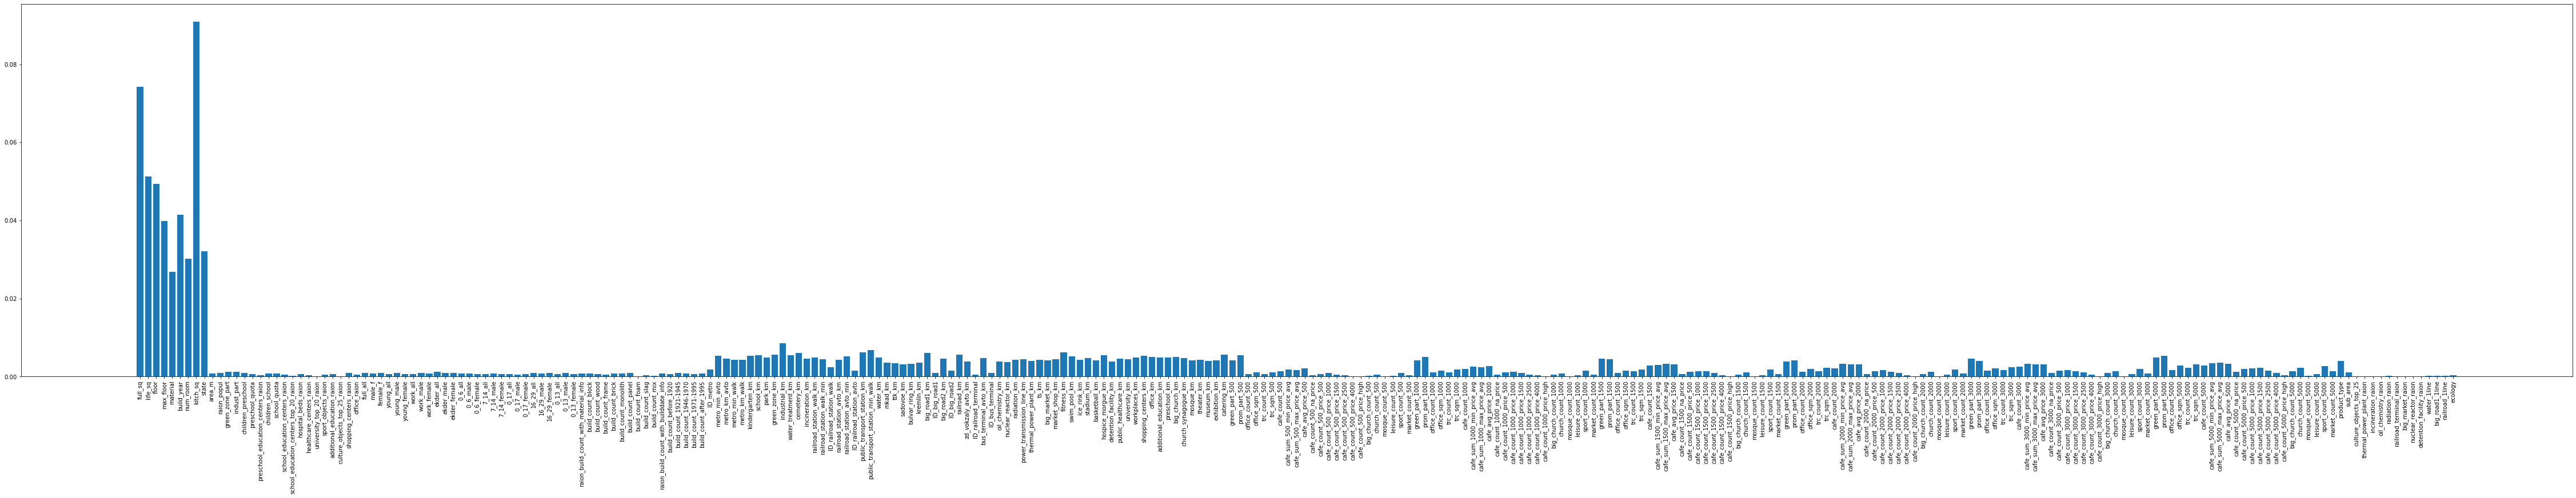

In [23]:
rf = RandomForestClassifier()
rf.fit(xdat, y)
rf_importance = rf.feature_importances_
features_to_drop = automated_feature_selection(rf_importance)

In [24]:
# check
features_to_drop

['kitch_sq',
 'full_sq',
 'life_sq',
 'floor',
 'build_year',
 'max_floor',
 'state',
 'num_room',
 'material']

Let's drop features that are important to distinguish train and test. This method is also called suppression. 

The only problem with this method is that you may actually be
forced to remove the majority of important variables from your data,
and any model you then build on such variable censored data won’t
be able to predict sufficiently correctly due to the lack of informative
features.

In [25]:
new_xdat = xdat.drop(features_to_drop, axis=1)

In [26]:
for train_index, test_index in skf.split(new_xdat, y):
        x0, x1 = new_xdat.iloc[train_index], new_xdat.iloc[test_index]
        y0, y1 = y.iloc[train_index], y.iloc[test_index]  
        
        clf.fit(x0, y0, eval_set=[(x1, y1)],
               eval_metric='logloss', verbose=False,early_stopping_rounds=10)
                
        prval = clf.predict_proba(x1)[:,1]
        print('For one fold, roc auc score: ', roc_auc_score(y1,prval))

C:\Users\004567\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:27:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


For one fold, roc auc score:  0.6885249219815925


C:\Users\004567\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:27:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


For one fold, roc auc score:  0.6851998618726278


C:\Users\004567\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:27:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


For one fold, roc auc score:  0.6920781318808124


C:\Users\004567\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:27:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


For one fold, roc auc score:  0.7057262590177729


C:\Users\004567\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:27:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


For one fold, roc auc score:  0.6943053176475427


As you see from the cross validation results above, roc auc score decreased after deleting features with high score. 

# Method 2: Validation Data Selection

Finally, with the strategy of validating by mimicking the test set,
you keep on training on all the data, but for validation purposes, you pick your examples only from train dataset which have similiar distribution.

In [108]:
xtrain = preprocess_data(xtrain)
xtest = preprocess_data(xtest)

For this reason, we will randomly select 250 samples from train dataset in each iteration and use two-sample Kolmogorov-Smirnov (KS) test, which is a non-parametric hypothesis test used to check whether validation candidate data and original test data originate from the same distribution.


If the number of non-rejected features more than rejected features at least three times, we accept the null hypothesis. In this case, we can say that the two sample datasets come from the same distribution. Then we combine these samples and we construct a new validation dataset, so by selecting from the training data so that the empirical distribution of the features data is similar to the test data.

This way, model evaluation metrics on the validation set should get similar results on the test set, which means if the model works well on the validation data, it should work well on the test data.

In [138]:
x_val = pd.DataFrame()

i = 0
while i<50:
    i+=1
    hypothesisnotrejected = []
    hypothesisrejected = []
    x_val_cand = xtrain.sample(250)

    for col in xtrain.columns:
        statistic, pvalue = stats.ks_2samp(x_val_cand[col], xtest[col])
        if pvalue>=statistic:
            hypothesisnotrejected.append(col)
        if pvalue<statistic:
            hypothesisrejected.append(col)

    rejection_proportion = len(hypothesisnotrejected)/len(hypothesisrejected)
    print(f'for {i} iteration:  {rejection_proportion}')

    if rejection_proportion>3:
        x_val = pd.concat([x_val, x_val_cand], axis = 0)
    x_val = x_val.drop_duplicates().reset_index(drop = True)

for 1 iteration:  3.7540983606557377
for 2 iteration:  3.328358208955224
for 3 iteration:  1.32
for 4 iteration:  12.80952380952381
for 5 iteration:  1.196969696969697
for 6 iteration:  4.0
for 7 iteration:  4.0
for 8 iteration:  2.0851063829787235
for 9 iteration:  0.7682926829268293
for 10 iteration:  3.6774193548387095
for 11 iteration:  4.178571428571429
for 12 iteration:  2.0526315789473686
for 13 iteration:  1.7358490566037736
for 14 iteration:  7.285714285714286
for 15 iteration:  1.4166666666666667
for 16 iteration:  1.4166666666666667
for 17 iteration:  1.543859649122807
for 18 iteration:  2.717948717948718
for 19 iteration:  2.258426966292135
for 20 iteration:  2.258426966292135


In [150]:
x_val.head()

full_sq  life_sq  floor  max_floor  material  build_year  num_room  \
0       60     -1.0   18.0       25.0       1.0        -1.0       2.0   
1       35     18.0    4.0        9.0       2.0      1972.0       1.0   
2       37     18.0    1.0       -1.0      -1.0        -1.0      -1.0   
3       55     38.0    5.0       -1.0      -1.0        -1.0      -1.0   
4       41     37.0    4.0       20.0       6.0        -1.0       1.0   

   kitch_sq  state        area_m  ...  oil_chemistry_raion  radiation_raion  \
0       1.0   -1.0  4.036700e+07  ...                    0                0   
1       5.0    3.0  5.586343e+06  ...                    0                0   
2      -1.0   -1.0  2.149409e+07  ...                    0                0   
3      -1.0   -1.0  7.759254e+06  ...                    0                0   
4      10.0    1.0  2.149409e+07  ...                    0                0   

   railroad_terminal_raion  big_market_raion  nuclear_reactor_raion  \
0                        0                 0                      0   
1                        0                 0                      0   
2                        0                 0                      0   
3                        0                 0                      0   
4                        0                 0                      0   

   detention_facility_raion  water_1line  big_road1_1line  railroad_1line  \
0                         0            0                0               0   
1                         0            0                0               0   
2                         0            1                0               0   
3                         0            0                0               0   
4                         0            1                0               0   

   ecology  
0        4  
1        2  
2        4  
3        4  
4        4  

[5 rows x 290 columns]

# Conclusion

From adversarial validation we have evidence that train and test sets come from different distributions. AUC around 0.99 states that XGBoost can easily distinguish train observations from test. These datasets are quite different. 

From Kolmogorov-Smirnov Test we can also state that both sets are quite different. Hypothesis that samples are drawn from the same distribution can rejected for 254 features out of 290 based on KS-Test. 

After proving concept drift we tried to solve the problem by two strategies: suppression and construct custom validaton set that the empirical distribution of the features data is similar to the test data. For Those Who Are Interested: In 2020, ML Engineers @Uber noticed concept drift problem in their “ML based User Targeting Automation Systems” project and they have written really great research paper. Take a look.